<a href="https://colab.research.google.com/github/pragmalingu/experiments/blob/02_BERT/02_Embeddings/Experiment/Second_Experiment_BERT_Embeddings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Second Experiment



For our second experiment we connect the Notebook to an Elasticsearch instance and compare a standard Elasticsearch operator with Embeddings we get from BERT (Bi-Directional Encoder Representation from Transformer). The Embeddings are indexed built-in stemming methods: 'Stemmer Token Filter' and 'Hunspell Token Filter'. 
(To read details about this experiment visit our [website](https://pragmalingu.de/docs/experiments/experiment1))

## Setup an Elasticsearch Instance in Google Colab

Everthing to connect to Elasticsearch, for detailed explaination see [this Notebook.](https://)
Download:

In [1]:
import os
from subprocess import Popen, PIPE, STDOUT
# download elasticsearch
!wget https://artifacts.elastic.co/downloads/elasticsearch/elasticsearch-7.9.1-linux-x86_64.tar.gz -q
!tar -xzf elasticsearch-7.9.1-linux-x86_64.tar.gz
!chown -R daemon:daemon elasticsearch-7.9.1


Start a local server:

In [2]:
# start server
es_server = Popen(['elasticsearch-7.9.1/bin/elasticsearch'], 
                  stdout=PIPE, stderr=STDOUT,
                  preexec_fn=lambda: os.setuid(1)  # as daemon
                 )
# client-side
!pip install elasticsearch -q
from elasticsearch import Elasticsearch
from datetime import datetime
es = Elasticsearch(["localhost:9200/"])
#wait a bit
import time
time.sleep(30)
es.ping()  # got True

     |████████████████████████████████| 225kB 4.3MB/s 


True

In [3]:
#print new index list
create_response = es.cat.indices()
print(create_response)

## Download and intializie pretrained BERT model

In [4]:
!pip install -U sentence-transformers

from sentence_transformers import SentenceTransformer
import torch
from tqdm import tqdm_notebook

model = SentenceTransformer('bert-base-nli-mean-tokens')

# using gpu to boost inference if it's possible
if torch.cuda.is_available():
  model.to('cuda')

print('Max Sequence Length:', model.max_seq_length)

#Change the length to max possible length (based on gpu memory)
model.max_seq_length = 364

print('Max Sequence Length:', model.max_seq_length)

     |████████████████████████████████| 71kB 3.2MB/s 
     |████████████████████████████████| 1.1MB 9.2MB/s 
     |████████████████████████████████| 3.0MB 19.2MB/s 
     |████████████████████████████████| 1.1MB 58.8MB/s 
     |████████████████████████████████| 890kB 57.5MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-0.3.8-cp36-none-any.whl size=101996 sha256=1d04f185e34b1f8db41b5f87d21788442f899e5f019ef3e42740be38a069e7ca
  Stored in directory: /root/.cache/pip/wheels/27/ec/b3/d12cc8e4daf77846db6543033d3a5642f204c0320b15945647
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=3c661c69d7f6a84efe58897c1a1627d27860f4a8b25b93c6eac7afa93c710ba3
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sentence-transformers sacremoses


100%|██████████| 405M/405M [00:24<00:00, 16.3MB/s]


Max Sequence Length: 128
Max Sequence Length: 364


## Parse Data

Get different corpora, format them and feed them to elasticsearch

### ADI Corpus

You can get the corpus from [this link](http://ir.dcs.gla.ac.uk/resources/test_collections/adi/).  <br>
For detailed information about the parsing of this corpus look at [ this Notebook](https://colab.research.google.com/github/pragmalingu/private_experiments/blob/adi_corpus/ADICorpus.ipynb) or for parsing in generel read [this guide](https://).

**Parsing**

In [5]:
# download and unzip data
!wget https://nextcloud.samyateia.de/index.php/s/ZWpy29gH4D2sADY/download
!tar -xf download
!rm download

# set paths to the dowloaded data as variables
PATH_TO_ADI_TXT = '/content/ADI.ALL'
PATH_TO_ADI_QRY = '/content/ADI.QRY'
PATH_TO_ADI_REL = '/content/ADI.REL'

from collections import defaultdict
import re
import json
from io import StringIO
import numpy as np


# get the text and query files

ID_marker = re.compile('\.I')

def get_data(PATH_TO_FILE, marker):
  """
  Reads file and spilts text into entries at the ID marker '.I'.
  First entry is empty, so it's removed.
  'marker' contains the regex at which we want to split
  """
  with open (PATH_TO_FILE,'r') as f:
    text = f.read().replace('\n'," ")
    lines = re.split(marker,text)
    lines.pop(0)
  return lines

adi_txt_list = get_data(PATH_TO_ADI_TXT, ID_marker)
adi_qry_list = get_data(PATH_TO_ADI_QRY, ID_marker)

# process text file

adi_title_start = re.compile('\.T')
adi_author_start = re.compile('\.A')
adi_text_start = re.compile('\.W')

adi_txt_data = defaultdict(dict)

for line in adi_txt_list:
  entries = re.split(adi_title_start,line,1)
  id = entries[0].strip()
  no_id = entries[1]
  if len(re.split(adi_author_start, no_id,1)) > 1:
    no_id_entries = re.split(adi_author_start, no_id,1)
    adi_txt_data[id]['title'] = no_id_entries[0]
    no_title = no_id_entries[1]
    no_title_entries = re.split(adi_text_start, no_title)
    adi_txt_data[id]['author'] = no_title_entries[0]
    adi_txt_data[id]['text'] = no_title_entries[1]
  else:
    no_id_entries = re.split(adi_text_start, no_id)
    adi_txt_data[id]['title'] = no_id_entries[0]
    adi_txt_data[id]['text'] = no_id_entries[1]

# process query file    

qry_chunk_start = re.compile('\.W')
adi_qry_data = defaultdict(dict)

for n in range(0,len(adi_qry_list)-1):
  line = adi_qry_list[n+1]
  _ , question = re.split(qry_chunk_start,line)
  adi_qry_data[n+1]['question'] = question

# process relevance assesment

adi_rel_data = open(PATH_TO_ADI_REL)
adi_np = np.loadtxt(adi_rel_data, dtype=float)

adi_rel = defaultdict(list)
for row in adi_np:
  adi_rel[int(row[0])].append(int(row[1])) 

# transform text to sentences for BERT text search

import nltk
from nltk import tokenize
from nltk.tokenize import sent_tokenize
nltk.download('punkt')

def text_to_sentences(string):
  sentences = tokenize.sent_tokenize(string)
  return sentences

for ID, doc in adi_txt_data.items():
  text = adi_txt_data[ID]['text']
  adi_txt_data[ID]['sentences'] = text_to_sentences(text)

--2020-11-11 09:20:16--  https://nextcloud.samyateia.de/index.php/s/ZWpy29gH4D2sADY/download
Resolving nextcloud.samyateia.de (nextcloud.samyateia.de)... 194.55.14.32
Connecting to nextcloud.samyateia.de (nextcloud.samyateia.de)|194.55.14.32|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 57344 (56K) [application/x-gzip]
Saving to: ‘download’

download            100%[===================>]  56.00K   190KB/s    in 0.3s    

2020-11-11 09:20:17 (190 KB/s) - ‘download’ saved [57344/57344]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


**Indexing**

In [6]:
# Elasticsearch settings, without using Opendistro
# Settings for BERT title search
settings_title = {
  "mappings": {
      "properties": {
          "title": {
              "type": "text"
              },
          "title_vector": {
           "type": "dense_vector",
           "dims": 768
            }
    }
  }
}

# Settings for BERT text search
settings_text = {
  "mappings": {
    "properties": {
      "text_vector": {
        "type": "nested",
        "properties": {
          "vector": {
            "type": "dense_vector",
            "dims": 768 
          }
        }
      },
     "text": {
        "type": "keyword"
    },
    }
  }
}

#create index, see https://elasticsearch-py.readthedocs.io/en/master/api.html#elasticsearch.client.IndicesClient.create
adi_index = "adi-corpus"
es.indices.delete(index=adi_index, ignore=[400, 404])
es.indices.create(adi_index)

adi_index_title = "bert-title-adi-corpus"
es.indices.delete(index=adi_index_title, ignore=[400, 404])
es.indices.create(adi_index_title, body=settings_title)

adi_index_text = "bert-text-adi-corpus"
es.indices.delete(index=adi_index_text, ignore=[400, 404])
es.indices.create(adi_index_text, body=settings_text)

{'acknowledged': True,
 'index': 'bert-text-adi-corpus',
 'shards_acknowledged': True}

In [7]:
for ID, doc_data in adi_txt_data.items():
    # index for match query
    es.index(index=adi_index, id=ID, body=doc_data)
    # index for BERT title search
    es.index(
      index=adi_index_title, 
      id=ID, 
      body={
          'title_vector': model.encode(adi_txt_data[ID]['title']),
          'title': adi_txt_data[ID]['title'],
          }
    )
    # index for BERT text search
    es.index(
      index=adi_index_text, 
      id=ID, 
      body={
          'text_vector': [{"vector": model.encode(text)} for text in adi_txt_data[ID]['sentences']],
          'text': adi_txt_data[ID]['text']
          }
    )

#print new index list
create_response = es.cat.indices()
print(create_response)

yellow open bert-title-adi-corpus 2HjfWGWYTKS7zzB2a4OAYA 1 1  74 0 1.1mb 1.1mb
yellow open bert-text-adi-corpus  mr60vROYRiqm1kvt6I-8LA 1 1 264 0   3mb   3mb
yellow open adi-corpus            FWkeRPi8RdiU2gpo2Xmzcg 1 1  82 0 228kb 228kb



### CACM Corpus

You can get the corpus from [this link](http://ir.dcs.gla.ac.uk/resources/test_collections/cacm/).  <br>
For detailed information about the format of the files, see the PragmaLingu [ Benchmarks](https://pragmalingu.de/docs/benchmarks/overview)

**Parsing**

In [8]:
# download and unzip data
!wget https://nextcloud.samyateia.de/index.php/s/s4WQLTc7DLYsAaZ/download
!tar -xf download
!rm download

# set paths to the dowloaded data as variablesDownload and unzip data.

PATH_TO_CACM_TXT = '/content/cacm.all'
PATH_TO_CACM_QRY = '/content/query.text'
PATH_TO_CACM_REL = '/content/qrels.text'
PATH_TO_CACM_COMMON_WORDS = '/content/common_words'

from collections import defaultdict
import re
import json
from io import StringIO
import numpy as np

# get the text and query files

ID_marker = re.compile('^\.I',re.MULTILINE)

def get_data(PATH_TO_FILE, marker):
  """
  Reads file and spilts text into entries at the ID marker '.I'.
  First entry is empty, so it's removed.
  'marker' contains the regex at which we want to split
  """
  with open (PATH_TO_FILE,'r') as f:
    text = f.read()
    lines = re.split(marker,text)
    lines.pop(0)
  return lines

cacm_txt_list = get_data(PATH_TO_CACM_TXT, ID_marker)
cacm_qry_list = get_data(PATH_TO_CACM_QRY, ID_marker)

# process text file

cacm_chunk_title = re.compile('\.[T]\n')
cacm_chunk_txt = re.compile('\n\.W\n') # not enough
cacm_chunk_txt_pub = re.compile('\.[W,B]')
cacm_chunk_publication = re.compile('\.[B]\n')
cacm_chunk_author = re.compile('^\.[A]\n', re.MULTILINE)
cacm_chunk_author_add_cross = re.compile('^\.[A,N,X]\n',re.MULTILINE) # not enough
cacm_chunk_add_cross = re.compile('\.[B,N,X]\n')


cacm_txt_data = defaultdict(dict)

for line in cacm_txt_list:
  entries= re.split(cacm_chunk_title,line)
  id = entries[0].strip() #save id
  no_id = entries[1]

  if len(re.split(cacm_chunk_txt, no_id)) == 2: # is there text
    no_id_entries = re.split(cacm_chunk_txt_pub, no_id,1)
    cacm_txt_data[id]['title'] = no_id_entries[0].strip() # save title
    cacm_txt_data[id]['text'] = no_id_entries[1].strip() # save text
    no_title_txt = no_id_entries[1]

    if len(re.split(cacm_chunk_author, no_title_txt)) == 2: # is there a auhtor
      no_title_entries = re.split(cacm_chunk_author_add_cross, no_title_txt)
      cacm_txt_data[id]['publication_date'] = no_title_entries[0].strip() # save publication date
      cacm_txt_data[id]['author'] = no_title_entries[1].strip() # save athor
      cacm_txt_data[id]['add_date'] = no_title_entries[2].strip() # save add date
      cacm_txt_data[id]['cross-references'] = no_title_entries[3].strip() # save cross-references

    else:
      no_title_entries = re.split(cacm_chunk_publication, no_title_txt)
      cacm_txt_data[id]['publication_date'] = no_title_entries[0].strip() # save publication date
      cacm_txt_data[id]['add_date'] = no_title_entries[1].strip() # save add date
      cacm_txt_data[id]['cross-references'] = no_title_entries[1].strip() # save cross-references

  else:
    no_id_entries = re.split(cacm_chunk_publication, no_id,1)
    cacm_txt_data[id]['title'] = no_id_entries[0].strip() # save title
    no_title = no_id_entries[1]

    if len(re.split(cacm_chunk_author, no_title,1)) == 2: # is there a auhtor
      no_title_entries = re.split(cacm_chunk_author_add_cross, no_title)
      cacm_txt_data[id]['publication_date'] = no_title_entries[0].strip() # save publication date
      cacm_txt_data[id]['author'] = no_title_entries[1].strip() # save athor
      cacm_txt_data[id]['add_date'] = no_title_entries[2].strip() # save add date
      cacm_txt_data[id]['cross-references'] = no_title_entries[3].strip() # save cross-references

    else:
      no_title_entries = re.split(cacm_chunk_add_cross, no_title)
      cacm_txt_data[id]['publication_date'] = no_title_entries[0].strip() # save publication date
      cacm_txt_data[id]['add_date'] = no_title_entries[1].strip() # save add date
      cacm_txt_data[id]['cross-references'] = no_title_entries[2].strip() # save cross-references

# process the query data

qry_chunk_start = re.compile('^\.W\n',re.MULTILINE)
cacm_qry_data = defaultdict(dict)

for n in range(0,len(cacm_qry_list)-1):
  line = cacm_qry_list[n+1]
  _ , question = re.split(qry_chunk_start,line)
  cacm_qry_data[n+1]['question'] = question

# process the relevance assesment data
cacm_rel = defaultdict(list)

with open (PATH_TO_CACM_REL,'r') as f:
  for line in f:
    line = re.split(' ',line)
    cacm_rel[int(line[0])].append(line[1])


# transform text to sentences for BERT text search

import nltk
from nltk import tokenize
from nltk.tokenize import sent_tokenize
nltk.download('punkt')

def text_to_sentences(string):
  sentences = tokenize.sent_tokenize(string)
  return sentences

for ID, doc in cacm_txt_data.items():
  if 'text' in cacm_txt_data[str(ID)]:
    text = cacm_txt_data[ID]['text']
    cacm_txt_data[ID]['sentences'] = text_to_sentences(text)

--2020-11-11 09:20:29--  https://nextcloud.samyateia.de/index.php/s/s4WQLTc7DLYsAaZ/download
Resolving nextcloud.samyateia.de (nextcloud.samyateia.de)... 194.55.14.32
Connecting to nextcloud.samyateia.de (nextcloud.samyateia.de)|194.55.14.32|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2221056 (2.1M) [application/x-gzip]
Saving to: ‘download’

download            100%[===================>]   2.12M  2.05MB/s    in 1.0s    

2020-11-11 09:20:31 (2.05 MB/s) - ‘download’ saved [2221056/2221056]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


**Indexing**

In [9]:
# Elasticsearch settings, without using Opendistro
# Settings for BERT title search
settings_title = {
  "mappings": {
      "properties": {
          "title": {
              "type": "text"
              },
          "title_vector": {
           "type": "dense_vector",
           "dims": 768
            }
    }
  }
}

# Settings for BERT title search
settings_text = {
  "mappings": {
    "properties": {
      "text_vector": {
        "type": "nested",
        "properties": {
          "vector": {
            "type": "dense_vector",
            "dims": 768 
          }
        }
      },
     "text": {
        "type": "keyword"
    },
    }
  }
}

#create index, see https://elasticsearch-py.readthedocs.io/en/master/api.html#elasticsearch.client.IndicesClient.create
cacm_index= "cacm-corpus"
es.indices.delete(index=cacm_index, ignore=[400, 404])
es.indices.create(cacm_index)

cacm_index_title = "bert-title-cacm-corpus"
es.indices.delete(index=cacm_index_title, ignore=[400, 404])
es.indices.create(cacm_index_title, body=settings_title)

cacm_index_text = "bert-text-cacm-corpus"
es.indices.delete(index=cacm_index_text, ignore=[400, 404])
es.indices.create(cacm_index_text, body=settings_text)

{'acknowledged': True,
 'index': 'bert-text-cacm-corpus',
 'shards_acknowledged': True}

In [10]:
for ID, doc_data in cacm_txt_data.items():
    # index for match query
    es.index(index=cacm_index, id=ID, body=doc_data)
    # index for BERT title search, not every entry has a title
    if 'title' not in cacm_txt_data[str(ID)]:
      es.index(
          index=cacm_index_title, 
          id=ID, 
          body={
              'title_vector': model.encode('none'),
              'title': '',
        }
  )
    else:
      es.index(
          index=cacm_index_title, 
          id=ID, 
          body={
              'title_vector': model.encode(cacm_txt_data[ID]['title']),
              'title': cacm_txt_data[ID]['title'],
              }
               )
    # index for BERT text search, not every entry has a title
    if 'text' not in cacm_txt_data[str(ID)]:
      es.index(
        index=cacm_index, 
        id=ID, 
        body={
            'text_vector': model.encode('none'),
            'text': ''
            }
             )
    else:
      es.index(
      index=cacm_index_text, 
      id=ID, 
      body={
          'text_vector': [{"vector": model.encode(text)} for text in cacm_txt_data[ID]['sentences']],
          'text': cacm_txt_data[ID]['text']
          }
    )
    

#print new index list
create_response = es.cat.indices()
print(create_response)

yellow open bert-title-cacm-corpus _F3i6g7GQ_ObyJOvYnrKPw 1 1 354   0  37.9mb  37.9mb
yellow open bert-title-adi-corpus  2HjfWGWYTKS7zzB2a4OAYA 1 1  82   0   1.2mb   1.2mb
yellow open cacm-corpus            X7CIofpRT628XOjFyqSntw 1 1 354 296  15.8mb  15.8mb
yellow open bert-text-cacm-corpus  C9DCyrpKToevGIOflTMlsQ 1 1 328   0 109.7mb 109.7mb
yellow open bert-text-adi-corpus   mr60vROYRiqm1kvt6I-8LA 1 1 285   0     3mb     3mb
yellow open adi-corpus             FWkeRPi8RdiU2gpo2Xmzcg 1 1  82   0 228.9kb 228.9kb



### CISI Corpus

You can get the corpus from [this link](http://ir.dcs.gla.ac.uk/resources/test_collections/cisi/).  <br>
For detailed information about the parsing of this corpus look at [ this Notebook](https://colab.research.google.com/github/pragmalingu/private_experiments/blob/cisi_corpus/CISICorpus.ipynb) or for parsing in generel read [this guide](https://).

**Parsing**

In [11]:
# download and unzip data
!wget https://nextcloud.samyateia.de/index.php/s/ibPgbdqsstrWEAa/download
!tar -xf download
!rm download

# set paths to the dowloaded data as variablesDownload and unzip data.
PATH_TO_CISI_TXT = '/content/CISI.ALL'
PATH_TO_CISI_QRY = '/content/CISI.QRY'
PATH_TO_CISI_REL = '/content/CISI.REL'

from collections import defaultdict
import re
import json
from io import StringIO
import numpy as np

# get the text and query files

ID_marker = re.compile('^\.I',re.MULTILINE)

def get_data(PATH_TO_FILE, marker):
  """
  Reads file and spilts text into entries at the ID marker '.I'.
  First entry is empty, so it's removed.
  'marker' contains the regex at which we want to split
  """
  with open (PATH_TO_FILE,'r') as f:
    text = f.read()
    lines = re.split(marker,text)
    lines.pop(0)
  return lines

cisi_txt_list = get_data(PATH_TO_CISI_TXT, ID_marker)
cisi_qry_list = get_data(PATH_TO_CISI_QRY, ID_marker)

# process text file

cisi_title_start = re.compile('[\n]\.T')
cisi_author_start = re.compile('[\n]\.A')
cisi_date_start = re.compile('[\n]\.B')
cisi_text_start = re.compile('[\n]\.W')
cisi_cross_start = re.compile('[\n]\.X')

cisi_txt_data = defaultdict(dict)

for line in cisi_txt_list:
  entries = re.split(cisi_title_start,line,1)
  id = entries[0].strip()#save the id
  no_id = entries[1] 
  
  if len(re.split(cisi_author_start, no_id)) >= 2: # is there just one author?
    no_id_entries = re.split(cisi_author_start, no_id,1)
    cisi_txt_data[id]['title'] = no_id_entries[0].strip() # save title
    no_title = no_id_entries[1]

    if len(re.split(cisi_date_start, no_title)) > 1: # is there a publication date?
      no_title_entries = re.split(cisi_date_start, no_title)
      cisi_txt_data[id]['author'] = no_title_entries[0].strip() # save athour
      no_author = no_title_entries[1]
      no_author_entries = re.split(cisi_text_start, no_author)
      cisi_txt_data[id]['publication_date'] = no_author_entries[0].strip() # save publication date
      no_author_date = no_author_entries[1]
    else:
      no_title_entries = re.split(cisi_text_start, no_title)
      cisi_txt_data[id]['author'] = no_title_entries[0].strip() # save athour
      no_author_date = no_title_entries[1]

  else:
    no_id_entries = re.split(cisi_author_start, no_id)
    cisi_txt_data[id]['title'] = no_id_entries[0].strip() # save title
    cisi_txt_data[id]['author'] = no_id_entries[1].strip() # save first author
    no_title_entries = re.split(cisi_text_start, no_title)
    cisi_txt_data[id]['author'] += ','+no_title_entries[0].strip() # save second athour
    no_author_date = no_title_entries[1]

  last_entries = re.split(cisi_cross_start, no_author_date)
  cisi_txt_data[id]['text'] = last_entries[0].strip() # save text
  cisi_txt_data[id]['cross-refrences'] = last_entries[1].strip() # save cross refrences

# process query file  

qry_chunk_start = re.compile('[\n]\.W')

cisi_qry_data = defaultdict(dict)

for line in cisi_qry_list:
  id , question = re.split(qry_chunk_start,line)
  id = re.findall('\d{1,3}',id)[0]
  cisi_qry_data[id]['question'] = question

# process the relevance assesment data
cisi_rel = defaultdict(list)

with open (PATH_TO_CISI_REL,'r') as f:
  for line in f:
    line = line.replace(' ','\t')
    line = re.split('\t',line)
    line = list(filter(None, line))
    cisi_rel[str(line[0])].append(str(line[1]))

# transform text to sentences for BERT text search

import nltk
from nltk import tokenize
from nltk.tokenize import sent_tokenize
nltk.download('punkt')

def text_to_sentences(string):
  sentences = tokenize.sent_tokenize(string)
  return sentences

for ID, doc in cisi_txt_data.items():
  text = cisi_txt_data[ID]['text']
  cisi_txt_data[ID]['sentences'] = text_to_sentences(text)

--2020-11-11 09:26:01--  https://nextcloud.samyateia.de/index.php/s/ibPgbdqsstrWEAa/download
Resolving nextcloud.samyateia.de (nextcloud.samyateia.de)... 194.55.14.32
Connecting to nextcloud.samyateia.de (nextcloud.samyateia.de)|194.55.14.32|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2385920 (2.3M) [application/x-gzip]
Saving to: ‘download’

download            100%[===================>]   2.28M  2.22MB/s    in 1.0s    

2020-11-11 09:26:03 (2.22 MB/s) - ‘download’ saved [2385920/2385920]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


**Indexing**

In [12]:
# Elasticsearch settings, without using Opendistro
# Settings for BERT title search
settings_title = {
  "mappings": {
      "properties": {
          "title": {
              "type": "text"
              },
          "title_vector": {
           "type": "dense_vector",
           "dims": 768
            }
    }
  }
}

# Settings for BERT text search
settings_text = {
  "mappings": {
    "properties": {
      "text_vector": {
        "type": "nested",
        "properties": {
          "vector": {
            "type": "dense_vector",
            "dims": 768 
          }
        }
      },
     "text": {
        "type": "keyword"
    },
    }
  }
}



#create index, see https://elasticsearch-py.readthedocs.io/en/master/api.html#elasticsearch.client.IndicesClient.create
cisi_index = "cisi-corpus"
es.indices.delete(index=cisi_index, ignore=[400, 404])
es.indices.create(cisi_index)

cisi_index_title = "bert-title-cisi-corpus"
es.indices.delete(index=cisi_index_title, ignore=[400, 404])
es.indices.create(cisi_index_title, body=settings_title)

cisi_index_text = "bert-text-cisi-corpus"
es.indices.delete(index=cisi_index_text, ignore=[400, 404])
es.indices.create(cisi_index_text, body=settings_text)

{'acknowledged': True,
 'index': 'bert-text-cisi-corpus',
 'shards_acknowledged': True}

In [13]:
for ID, doc_data in cisi_txt_data.items():
    # Index for match query
    es.index(index=cisi_index, id=ID, body=doc_data)
    # Index for BERT title search
    es.index(
      index=cisi_index_title, 
      id=ID, 
      body={
          'title_vector': model.encode(cisi_txt_data[ID]['title']),
          'title': cisi_txt_data[ID]['title'],
          }
    )
    # Index for BERT text search
    es.index(
      index=cisi_index_text, 
      id=ID, 
      body={
          'text_vector': [{"vector": model.encode(text)} for text in cisi_txt_data[ID]['sentences']],
          'text': cisi_txt_data[ID]['text']
          }
    )

#print new index list
create_response = es.cat.indices()
print(create_response)

yellow open bert-title-cacm-corpus _F3i6g7GQ_ObyJOvYnrKPw 1 1  354   0  37.9mb  37.9mb
yellow open bert-title-cisi-corpus OzdfY0HMTD6sNMLwEBPmlw 1 1  217   0  19.4mb  19.4mb
yellow open bert-title-adi-corpus  2HjfWGWYTKS7zzB2a4OAYA 1 1   82   0   1.2mb   1.2mb
yellow open cacm-corpus            X7CIofpRT628XOjFyqSntw 1 1  354 296  15.8mb  15.8mb
yellow open bert-text-cacm-corpus  C9DCyrpKToevGIOflTMlsQ 1 1  328   0 109.7mb 109.7mb
yellow open bert-text-adi-corpus   mr60vROYRiqm1kvt6I-8LA 1 1  285   0     3mb     3mb
yellow open cisi-corpus            F-GybcLDQjSWagVf9P_5PA 1 1  217   0   2.6mb   2.6mb
yellow open adi-corpus             FWkeRPi8RdiU2gpo2Xmzcg 1 1   82   0 228.9kb 228.9kb
yellow open bert-text-cisi-corpus  cI7Sye3MT9C8lZXa5RfrZQ 1 1 1288   0  89.5mb  89.5mb



### Cranfield Corpus


You can get the corpus from [this link](http://ir.dcs.gla.ac.uk/resources/test_collections/cran/).  <br>
For detailed information about the parsing of this corpus look at [ this Notebook](https://colab.research.google.com/github/pragmalingu/private_experiments/blob/cranfield_corpus/CranfieldCorpus.ipynb) or for parsing in generel read [this guide](https://).

**Parsing**

In [14]:
# download and unzip data
!wget https://nextcloud.samyateia.de/index.php/s/ePSxPpLELCWteeL/download
!tar -xf download
!rm download

# set paths to the dowloaded data as variables
PATH_TO_CRAN_TXT = '/content/cran.all.1400'
PATH_TO_CRAN_QRY = '/content/cran.qry'
PATH_TO_CRAN_REL = '/content/cranqrel'

from collections import defaultdict
import re
import json
from io import StringIO
import numpy as np


# get the text entries from the text and query files

ID_marker = re.compile('\.I')

def get_data(PATH_TO_FILE, marker):
  """
  Reads file and spilts text into entries at the ID marker '.I'.
  First entry is empty, so it's removed.
  'marker' contains the regex at which we want to split
  """
  with open (PATH_TO_FILE,'r') as f:
    text = f.read().replace('\n'," ")
    lines = re.split(marker,text)
    lines.pop(0)
  return lines

cran_txt_list = get_data(PATH_TO_CRAN_TXT, ID_marker)
cran_qry_list = get_data(PATH_TO_CRAN_QRY, ID_marker)

# process text file

cran_chunk_start = re.compile('\.[A,B,T,W]')
cran_txt_data = defaultdict(dict)

for line in cran_txt_list:
  entries= re.split(cran_chunk_start,line)
  id = entries[0].strip()
  title = entries[1]
  author = entries[2]
  publication_date = entries[3]
  text = entries[4:]
  cran_txt_data[id]['title'] = title
  cran_txt_data[id]['author'] = author
  cran_txt_data[id]['publication_date'] = publication_date
  cran_txt_data[id]['text'] = ''.join(text)

# process query file

qry_chunk_start = re.compile('\.W')
cran_qry_data = defaultdict(dict)

for n in range(0,len(cran_qry_list)-1):
  line = cran_qry_list[n+1]
  _ , question = re.split(qry_chunk_start,line)
  cran_qry_data[n+1]['question'] = question

# process relevance assesments without rating
cran_rel = defaultdict(list)

with open (PATH_TO_CRAN_REL,'r') as f:
  for line in f:
    line = re.split(' ',line)
    cran_rel[int(line[0])].append(line[1])

# transform text to sentences for BERT text search
import nltk
from nltk import tokenize
from nltk.tokenize import sent_tokenize
nltk.download('punkt')

def text_to_sentences(string):
  sentences = tokenize.sent_tokenize(string)
  return sentences

for ID, doc in cran_txt_data.items():
  if 'text' in cran_txt_data[str(ID)]:
    text = cran_txt_data[ID]['text']
    cran_txt_data[ID]['sentences'] = text_to_sentences(text)

--2020-11-11 09:28:55--  https://nextcloud.samyateia.de/index.php/s/ePSxPpLELCWteeL/download
Resolving nextcloud.samyateia.de (nextcloud.samyateia.de)... 194.55.14.32
Connecting to nextcloud.samyateia.de (nextcloud.samyateia.de)|194.55.14.32|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1698816 (1.6M) [application/x-gzip]
Saving to: ‘download’

download            100%[===================>]   1.62M  1.57MB/s    in 1.0s    

2020-11-11 09:28:56 (1.57 MB/s) - ‘download’ saved [1698816/1698816]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


**Indexing**

In [15]:
# Elasticsearch settings, without using Opendistro
# Settings for BERT title search
settings_title = {
  "mappings": {
      "properties": {
          "title": {
              "type": "text"
              },
          "title_vector": {
           "type": "dense_vector",
           "dims": 768
            }
    }
  }
}
# Settings for BERT text search
settings_text = {
  "mappings": {
    "properties": {
      "text_vector": {
        "type": "nested",
        "properties": {
          "vector": {
            "type": "dense_vector",
            "dims": 768 
          }
        }
      },
     "text": {
        "type": "keyword"
    },
    }
  }
}
#create index, see https://elasticsearch-py.readthedocs.io/en/master/api.html#elasticsearch.client.IndicesClient.create

cran_index = "cranfield-corpus"
es.indices.delete(index=cran_index, ignore=[400, 404])
es.indices.create(cran_index)

cran_index_title = "bert-title-cranfield-corpus"
es.indices.delete(index=cran_index_title, ignore=[400, 404])
es.indices.create(cran_index_title, body=settings_title)

cran_index_text = "bert-text-cranfield-corpus"
es.indices.delete(index=cran_index_text, ignore=[400, 404])
es.indices.create(cran_index_text, body=settings_text)

{'acknowledged': True,
 'index': 'bert-text-cranfield-corpus',
 'shards_acknowledged': True}

In [16]:
#index documents, see https://elasticsearch-py.readthedocs.io/en/master/#example-usage
for ID, doc_data in cran_txt_data.items():
      # Index for match query
      es.index(index=cran_index, id=ID, body=doc_data)
      # Index for BERT title search
      es.index(
         index=cran_index_title, 
         id=ID, 
         body={
          'title_vector': model.encode(cran_txt_data[ID]['title']),
          'title': cran_txt_data[ID]['title'],
          }
    )
      # Index for BERT text search
      es.index(
            index=cran_index_text, 
            id=ID, 
            body={
          'text_vector': [{"vector": model.encode(text)} for text in cran_txt_data[ID]['sentences']],
          'text': cran_txt_data[ID]['text']
          }
    )
      

#print new index list
create_response = es.cat.indices()
print(create_response)

yellow open bert-title-cacm-corpus      _F3i6g7GQ_ObyJOvYnrKPw 1 1  3204    0  46.3mb  46.3mb
yellow open bert-title-cisi-corpus      OzdfY0HMTD6sNMLwEBPmlw 1 1   217    0  19.4mb  19.4mb
yellow open bert-title-adi-corpus       2HjfWGWYTKS7zzB2a4OAYA 1 1    82    0   1.2mb   1.2mb
yellow open bert-text-cranfield-corpus  pwtNMrrdR2uOGwbq7p5SWA 1 1  1402    0   143mb   143mb
yellow open cranfield-corpus            CzTSKHOfQUys57Ta0CCydQ 1 1   165    0   2.1mb   2.1mb
yellow open cacm-corpus                 X7CIofpRT628XOjFyqSntw 1 1  3204 1618  26.4mb  26.4mb
yellow open bert-title-cranfield-corpus FJnC-cwlQ8qJLvCdbKctUw 1 1   165    0    18mb    18mb
yellow open bert-text-adi-corpus        mr60vROYRiqm1kvt6I-8LA 1 1   285    0     3mb     3mb
yellow open bert-text-cacm-corpus       C9DCyrpKToevGIOflTMlsQ 1 1 10685    0 138.4mb 138.4mb
yellow open cisi-corpus                 F-GybcLDQjSWagVf9P_5PA 1 1   217    0   2.6mb   2.6mb
yellow open bert-text-cisi-corpus       cI7Sye3MT9C8lZXa5Rfr

### LISA Corpus

You can get the corpus from [this link](http://ir.dcs.gla.ac.uk/resources/test_collections/lisa/).  <br>
For detailed information about the format of the files, see the PragmaLingu [ Benchmarks](https://pragmalingu.de/docs/benchmarks/overview)

**Parsing**

In [17]:
# download and unzip data
!wget https://nextcloud.samyateia.de/index.php/s/Ed8gekyDgpkGGQ6/download
!tar -xf download
!rm download

# set paths to the dowloaded data as variablesDownload and unzip data.

PATH_TO_LISA_TXT = '/content/'
PATH_TO_LISA_QRY = '/content/LISA.QUE'
PATH_TO_LISA_REL = '/content/LISARJ.NUM'

from collections import defaultdict
import re
import json
from io import StringIO
import numpy as np
import os

# get the text and query files

file_regex = re.compile('LISA[0-5]')
lisa_files = [i for i in os.listdir(PATH_TO_LISA_TXT) if os.path.isfile(os.path.join(PATH_TO_LISA_TXT,i)) and re.match(file_regex,i)]

txt_entry_marker = re.compile('\*{44}',re.MULTILINE)
qry_entry_marker = re.compile('#')

def get_data(PATH_TO_FILES, marker):
  """
  Reads multiple files and spilts text into entries at the entry marker.
  The 'marker' contains the regex at which we want to split
  Pops last element since it's empty.
  """
  with open (PATH_TO_FILES,'r') as f:
    text = f.read().replace('     ','')
    lines = re.split(marker,text)
    lines.pop()
  return lines

lisa_txt_list = []
for name in lisa_files: 
  lisa_txt_list.extend(get_data(PATH_TO_LISA_TXT+name, txt_entry_marker))

lisa_qry_list = get_data(PATH_TO_LISA_QRY, qry_entry_marker)

# process text file

doc_strip = re.compile('\n?Document {1,2}')

lisa_txt_list_stripped = []
lisa_txt_data = defaultdict(dict)

for el in lisa_txt_list:
  lisa_txt_list_stripped.append(re.sub(doc_strip,'', el))

for entry in lisa_txt_list_stripped:
  parts = entry.split('\n')
  empty_index = parts.index('')
  ID = parts[0].strip(' ')
  title = parts[1:empty_index]
  text = parts[empty_index+1:]
  lisa_txt_data[ID]['title'] = ''.join(title)
  lisa_txt_data[ID]['text'] = ''.join(text)

# process the query data

lisa_qry_data = defaultdict(dict)
# first line is a special case because it doesn't start with a newline
first_line = lisa_qry_list[0]
first_question = ' '.join(first_line[1:])
lisa_qry_data[int(first_line[0])]['question'] = first_question

# after that every line can be handle the same way
for n in range(0,len(lisa_qry_list)-1):
  line = re.split('\n',lisa_qry_list[n+1])
  question = ' '.join(line[2:])
  lisa_qry_data[int(line[1])]['question'] = question

# process relevance assesments
lisa_rel = defaultdict(list)

rel_marker = re.compile('            \n        ')
rel_split = re.compile('\n')

with open (PATH_TO_LISA_REL,'r') as f:
  file = f.read().strip('       ').replace('\n','')
  lines = re.split(' ',file)
  lines = list(filter(None, lines))
  n = 0
  while n < len(lines):
    ID = int(lines[n])
    num_rel = int(lines[n+1])
    rels = lines[(n+2):(n+num_rel+2)]
    lisa_rel[ID].extend(rels)
    n = n+1+num_rel+1

# transform text to sentences for BERT text search
import nltk
from nltk import tokenize
from nltk.tokenize import sent_tokenize
nltk.download('punkt')

def text_to_sentences(string):
  sentences = tokenize.sent_tokenize(string)
  return sentences

for ID, doc in lisa_txt_data.items():
  text = lisa_txt_data[ID]['text']
  lisa_txt_data[ID]['sentences'] = text_to_sentences(text)

--2020-11-11 09:32:51--  https://nextcloud.samyateia.de/index.php/s/Ed8gekyDgpkGGQ6/download
Resolving nextcloud.samyateia.de (nextcloud.samyateia.de)... 194.55.14.32
Connecting to nextcloud.samyateia.de (nextcloud.samyateia.de)|194.55.14.32|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4012544 (3.8M) [application/x-gzip]
Saving to: ‘download’

download            100%[===================>]   3.83M  3.26MB/s    in 1.2s    

2020-11-11 09:32:53 (3.26 MB/s) - ‘download’ saved [4012544/4012544]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


**Indexing**

In [18]:
# Elasticsearch settings, without using Opendistro
# Settings for BERT title search
settings_title = {
  "mappings": {
      "properties": {
          "title": {
              "type": "text"
              },
          "title_vector": {
           "type": "dense_vector",
           "dims": 768
            }
    }
  }
}
# Settings for BERT text search
settings_text = {
  "mappings": {
    "properties": {
      "text_vector": {
        "type": "nested",
        "properties": {
          "vector": {
            "type": "dense_vector",
            "dims": 768 
          }
        }
      },
     "text": {
        "type": "keyword"
    },
    }
  }
}
#create index, see https://elasticsearch-py.readthedocs.io/en/master/api.html#elasticsearch.client.IndicesClient.create
lisa_index = "lisa-corpus"
es.indices.delete(index=lisa_index, ignore=[400, 404])
es.indices.create(lisa_index)

lisa_index_title = "bert-title-lisa-corpus"
es.indices.delete(index=lisa_index_title, ignore=[400, 404])
es.indices.create(lisa_index_title, body=settings_title)

lisa_index_text = "bert-text-lisa-corpus"
es.indices.delete(index=lisa_index_text, ignore=[400, 404])
es.indices.create(lisa_index_text, body=settings_text)

{'acknowledged': True,
 'index': 'bert-text-lisa-corpus',
 'shards_acknowledged': True}

In [19]:
for ID, doc_data in lisa_txt_data.items():
    # Index for match query
    es.index(index=lisa_index, id=ID, body=doc_data)
    # Index for BERT title search
    es.index(
      index=lisa_index_title, 
      id=ID, 
      body={
          'title_vector': model.encode(''.join(lisa_txt_data[ID]['title'])),
          'title': lisa_txt_data[ID]['title'],
          }
    )
    # Index for BERT text search
    es.index(
      index=lisa_index_text, 
      id=ID, 
      body={
          'text_vector': [{"vector": model.encode(text)} for text in lisa_txt_data[ID]['sentences']],
          'text': lisa_txt_data[ID]['text']
          }
    )
#print new index list
create_response = es.cat.indices()
print(create_response)

yellow open bert-title-lisa-corpus      nBVwo3YQSRqe-YXHWqEq0Q 1 1   275    0  72.3mb  72.3mb
yellow open bert-title-adi-corpus       2HjfWGWYTKS7zzB2a4OAYA 1 1    82    0   1.2mb   1.2mb
yellow open cranfield-corpus            CzTSKHOfQUys57Ta0CCydQ 1 1  1400    0   4.5mb   4.5mb
yellow open bert-title-cranfield-corpus FJnC-cwlQ8qJLvCdbKctUw 1 1  1400    0    20mb    20mb
yellow open bert-text-adi-corpus        mr60vROYRiqm1kvt6I-8LA 1 1   285    0     3mb     3mb
yellow open bert-text-lisa-corpus       40MYkfsIRra6oiBzW_ka9w 1 1  1270    0 253.6mb 253.6mb
yellow open adi-corpus                  FWkeRPi8RdiU2gpo2Xmzcg 1 1    82    0 228.9kb 228.9kb
yellow open lisa-corpus                 YcTXzVjXRIazJlt8gOnNAw 1 1   275    0   3.4mb   3.4mb
yellow open bert-title-cacm-corpus      _F3i6g7GQ_ObyJOvYnrKPw 1 1  3204    0  46.3mb  46.3mb
yellow open bert-title-cisi-corpus      OzdfY0HMTD6sNMLwEBPmlw 1 1  1460    0  21.1mb  21.1mb
yellow open bert-text-cranfield-corpus  pwtNMrrdR2uOGwbq7p5S

### Medline Corpus

You can get the corpus from [this link](http://ir.dcs.gla.ac.uk/resources/test_collections/med/).  <br>
For detailed information about the format of the files, see the PragmaLingu [ Benchmarks](https://pragmalingu.de/docs/benchmarks/overview)

**Parsing**

In [20]:
# download and unzip data
!wget https://nextcloud.samyateia.de/index.php/s/MrAgWHEJYMT6HN2/download
!tar -xf download
!rm download

# set paths to the dowloaded data as variables
PATH_TO_MED_TXT = '/content/MED.ALL'
PATH_TO_MED_QRY = '/content/MED.QRY'
PATH_TO_MED_REL = '/content/MED.REL'

from collections import defaultdict
import re
import json
from io import StringIO
import numpy as np


# get the text and query files

ID_marker = re.compile('\.I')

def get_data(PATH_TO_FILE, marker):
  """
  Reads file and spilts text into entries at the ID marker '.I'.
  First entry is empty, so it's removed.
  'marker' contains the regex at which we want to split
  """
  with open (PATH_TO_FILE,'r') as f:
    text = f.read().replace('\n'," ")
    lines = re.split(marker,text)
    lines.pop(0)
  return lines

med_txt_list = get_data(PATH_TO_MED_TXT, ID_marker)
med_qry_list = get_data(PATH_TO_MED_QRY, ID_marker)

# process the text and query files

import nltk
from nltk import tokenize
from nltk.tokenize import sent_tokenize
nltk.download('punkt')

def text_to_sentences(string):
  sentences = tokenize.sent_tokenize(string)
  return sentences

qry_chunk_start = re.compile('\.W')

med_txt_data = defaultdict(dict)
med_qry_data = defaultdict(dict)

def fill_dictionary(dictionary, chunk_list, marker, key_name):
  for n in range(0,len(chunk_list)-1):
    line = chunk_list[n+1]
    _ , chunk = re.split(marker,line)
    dictionary[n+1][key_name] = chunk.strip()

fill_dictionary(med_txt_data, med_txt_list, qry_chunk_start, 'text')
fill_dictionary(med_qry_data, med_qry_list, qry_chunk_start, 'question')



# process relevance assesments with rating

med_rel_data = open(PATH_TO_MED_REL)
med_np = np.loadtxt(med_rel_data, dtype=int)

med_rel_rat = defaultdict(list)
for row in med_np:
  med_rel_rat[row[0]].append(row[2])

# process relevance assesments without rating
med_rel = defaultdict(list)

with open (PATH_TO_MED_REL,'r') as f:
  for line in f:
    line = re.split(' ',line)
    med_rel[int(line[0])].append(line[2])


# transform text to sentences for BERT text search
import nltk
from nltk import tokenize
from nltk.tokenize import sent_tokenize
nltk.download('punkt')

def text_to_sentences(string):
  sentences = tokenize.sent_tokenize(string)
  return sentences

for ID, doc in med_txt_data.items():
  text = med_txt_data[ID]['text']
  med_txt_data[ID]['sentences'] = text_to_sentences(text)


--2020-11-11 09:42:33--  https://nextcloud.samyateia.de/index.php/s/MrAgWHEJYMT6HN2/download
Resolving nextcloud.samyateia.de (nextcloud.samyateia.de)... 194.55.14.32
Connecting to nextcloud.samyateia.de (nextcloud.samyateia.de)|194.55.14.32|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1149440 (1.1M) [application/x-gzip]
Saving to: ‘download’

download            100%[===================>]   1.10M  1.25MB/s    in 0.9s    

2020-11-11 09:42:35 (1.25 MB/s) - ‘download’ saved [1149440/1149440]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


**Indexing**

We won't index the title BERT search because Medline, NPL and Time don't have titles.

In [21]:
# Elasticsearch settings, without using Opendistro
# Settings for BERT text search
settings_text = {
  "mappings": {
    "properties": {
      "text_vector": {
        "type": "nested",
        "properties": {
          "vector": {
            "type": "dense_vector",
            "dims": 768 
          }
        }
      },
     "text": {
        "type": "keyword"
    },
    }
  }
}

#create index, see https://elasticsearch-py.readthedocs.io/en/master/api.html#elasticsearch.client.IndicesClient.create
med_index = "medline-corpus"
es.indices.delete(index=med_index, ignore=[400, 404])
es.indices.create(med_index)

med_index_text = "bert-text-medline-corpus"
es.indices.delete(index=med_index_text, ignore=[400, 404])
es.indices.create(med_index_text, body=settings_text)

{'acknowledged': True,
 'index': 'bert-text-medline-corpus',
 'shards_acknowledged': True}

In [22]:
for ID, doc_data in med_txt_data.items():
  # Index for match query
  es.index(index=med_index, id=ID, body=doc_data)
  # Index for BERT text search
  es.index(
      index=med_index_text, 
      id=ID, 
      body={
          'text_vector': [{"vector": model.encode(text)} for text in med_txt_data[ID]['sentences']],
          'text': med_txt_data[ID]['text']
          }
    )

#print new index list
create_response = es.cat.indices()
print(create_response)

yellow open bert-title-lisa-corpus      nBVwo3YQSRqe-YXHWqEq0Q 1 1   275    0  72.4mb  72.4mb
yellow open bert-title-adi-corpus       2HjfWGWYTKS7zzB2a4OAYA 1 1    82    0   1.2mb   1.2mb
yellow open cranfield-corpus            CzTSKHOfQUys57Ta0CCydQ 1 1  1400    0   4.5mb   4.5mb
yellow open bert-title-cranfield-corpus FJnC-cwlQ8qJLvCdbKctUw 1 1  1400    0    20mb    20mb
yellow open bert-text-lisa-corpus       40MYkfsIRra6oiBzW_ka9w 1 1 25833    0 314.3mb 314.3mb
yellow open bert-text-adi-corpus        mr60vROYRiqm1kvt6I-8LA 1 1   285    0     3mb     3mb
yellow open adi-corpus                  FWkeRPi8RdiU2gpo2Xmzcg 1 1    82    0 228.9kb 228.9kb
yellow open medline-corpus              09tpqaI2Tm2Exf3Wn3WAzA 1 1   197    0   1.7mb   1.7mb
yellow open lisa-corpus                 YcTXzVjXRIazJlt8gOnNAw 1 1   275    0   3.4mb   3.4mb
yellow open bert-title-cacm-corpus      _F3i6g7GQ_ObyJOvYnrKPw 1 1  3204    0  46.3mb  46.3mb
yellow open bert-title-cisi-corpus      OzdfY0HMTD6sNMLwEBPm

### NPL Corpus

You can get the corpus from [this link](http://ir.dcs.gla.ac.uk/resources/test_collections/npl/).  <br>
For detailed information about the format of the files, see the PragmaLingu [ Benchmarks](https://pragmalingu.de/docs/benchmarks/overview)

**Parsing**

In [23]:
# download and unzip data
!wget https://nextcloud.samyateia.de/index.php/s/R9NjseQTwqc8PcR/download
!tar -xf download
!rm download

# set paths to the dowloaded data as variablesDownload and unzip data.

PATH_TO_NPL_TXT = '/content/doc-text'
PATH_TO_NPL_QRY = '/content/query-text'
PATH_TO_NPL_REL = '/content/rlv-ass'

from collections import defaultdict
import re
import json
from io import StringIO
import numpy as np
import os

npl_index = "npl-corpus"

# get the text, query and rel files

txt_entry_marker = re.compile('\n   /\n')
qry_entry_marker = re.compile('\n/\n')
rel_entry_marker = re.compile('\n   /\n')

def get_data(PATH_TO_FILES, marker):
  """
  Reads multiple files and spilts text into entries at the entry marker.
  The 'marker' contains the regex at which we want to split
  Pops last element since it's empty.
  """
  with open (PATH_TO_FILES,'r') as f:
    text = f.read()
    lines = re.split(marker,text)
    lines.pop()
  return lines

npl_txt_list = get_data(PATH_TO_NPL_TXT, txt_entry_marker)
npl_qry_list = get_data(PATH_TO_NPL_QRY, qry_entry_marker)
npl_rel_list = get_data(PATH_TO_NPL_REL, rel_entry_marker)

# process the documents

npl_txt_data = defaultdict(dict)

for entry in npl_txt_list:
  splitted = entry.split('\n')
  splitted = list(filter(None, splitted))
  ID = splitted[0]
  text = ' '.join(map(str, splitted[1:]))
  npl_txt_data[ID]['text'] = text

# process the queries

npl_qry_data = defaultdict(dict)

for entry in npl_qry_list:
  splitted = entry.split('\n')
  splitted = list(filter(None, splitted))
  ID = int(splitted[0])
  question = ' '.join(map(str, splitted[1:]))
  npl_qry_data[ID]['question'] = question

# process relevance assesments

npl_rel = defaultdict(list)

for entry in npl_rel_list:
  splitted = entry.replace('\n','').split(' ')
  splitted = list(filter(None, splitted))
  ID = int(splitted[0])
  npl_rel[ID].extend(splitted[1:]) 

# transform text to sentences for BERT text search
import nltk
from nltk import tokenize
from nltk.tokenize import sent_tokenize
nltk.download('punkt')

def text_to_sentences(string):
  sentences = tokenize.sent_tokenize(string)
  return sentences

for ID, doc in npl_txt_data.items():
  text = npl_txt_data[ID]['text']
  npl_txt_data[ID]['sentences'] = text_to_sentences(text)

--2020-11-11 09:44:59--  https://nextcloud.samyateia.de/index.php/s/R9NjseQTwqc8PcR/download
Resolving nextcloud.samyateia.de (nextcloud.samyateia.de)... 194.55.14.32
Connecting to nextcloud.samyateia.de (nextcloud.samyateia.de)|194.55.14.32|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6428672 (6.1M) [application/x-gzip]
Saving to: ‘download’

download            100%[===================>]   6.13M  5.04MB/s    in 1.2s    

2020-11-11 09:45:01 (5.04 MB/s) - ‘download’ saved [6428672/6428672]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


**Indexing**

We won't index the title BERT search because Medline, NPL and Time don't have titles.

In [24]:
# Elasticsearch settings, without using Opendistro
# Settings for BERT text search
settings_text = {
  "mappings": {
    "properties": {
      "text_vector": {
        "type": "nested",
        "properties": {
          "vector": {
            "type": "dense_vector",
            "dims": 768 
          }
        }
      },
     "text": {
        "type": "keyword"
    },
    }
  }
}

#create index, see https://elasticsearch-py.readthedocs.io/en/master/api.html#elasticsearch.client.IndicesClient.create

npl_index = "npl-corpus"
es.indices.delete(index=npl_index, ignore=[400, 404])
es.indices.create(npl_index)

npl_index_text = "bert-text-npl-corpus"
es.indices.delete(index=npl_index_text, ignore=[400, 404])
es.indices.create(npl_index_text, body=settings_text)

{'acknowledged': True,
 'index': 'bert-text-npl-corpus',
 'shards_acknowledged': True}

In [25]:
for ID, doc_data in npl_txt_data.items():
  # Index for match query
  es.index(index=npl_index, id=ID, body=doc_data)
  # Index for BERT text search
  text_list = []
  es.index(
      index=npl_index_text, 
      id=ID, 
      body={
          'text_vector': [{"vector": model.encode(text)} for text in npl_txt_data[ID]['sentences']],
          'text': npl_txt_data[ID]['text']
          }
    )

#print new index list
create_response = es.cat.indices()
print(create_response)

yellow open bert-text-npl-corpus        JhJrkQhtRpOH36ptEwMq9Q 1 1  1812    0 147.5mb 147.5mb
yellow open bert-title-lisa-corpus      nBVwo3YQSRqe-YXHWqEq0Q 1 1  6000    0  86.9mb  86.9mb
yellow open bert-title-adi-corpus       2HjfWGWYTKS7zzB2a4OAYA 1 1    82    0   1.2mb   1.2mb
yellow open cranfield-corpus            CzTSKHOfQUys57Ta0CCydQ 1 1  1400    0   4.5mb   4.5mb
yellow open bert-title-cranfield-corpus FJnC-cwlQ8qJLvCdbKctUw 1 1  1400    0    20mb    20mb
yellow open bert-text-adi-corpus        mr60vROYRiqm1kvt6I-8LA 1 1   285    0     3mb     3mb
yellow open bert-text-lisa-corpus       40MYkfsIRra6oiBzW_ka9w 1 1 25833    0 299.7mb 299.7mb
yellow open adi-corpus                  FWkeRPi8RdiU2gpo2Xmzcg 1 1    82    0 228.9kb 228.9kb
yellow open medline-corpus              09tpqaI2Tm2Exf3Wn3WAzA 1 1  1032    0   3.2mb   3.2mb
yellow open lisa-corpus                 YcTXzVjXRIazJlt8gOnNAw 1 1  6000    0  10.1mb  10.1mb
yellow open bert-title-cacm-corpus      _F3i6g7GQ_ObyJOvYnrK

### Time Corpus



You can get the corpus from [this link](http://ir.dcs.gla.ac.uk/resources/test_collections/time/).  <br>
For detailed information about the format of the files, see the PragmaLingu [ Benchmarks](https://pragmalingu.de/docs/benchmarks/overview)

**Parsing**

In [26]:
# download and unzip data
!wget https://nextcloud.samyateia.de/index.php/s/9z7pMCNwXKCC2bY/download
!tar -xf download
!rm download

# set paths to the dowloaded data as variablesDownload and unzip data.

PATH_TO_TIME_TXT = '/content/TIME.ALL'
PATH_TO_TIME_QRY = '/content/TIME.QUE'
PATH_TO_TIME_REL = '/content/TIME.REL'

from collections import defaultdict
import re
import json
from io import StringIO
import numpy as np
import os

time_index = "time-corpus"

# get the text and query files

txt_entry_marker = re.compile('\*TEXT')
qry_entry_marker = re.compile('\*FIND    ')
def get_data(PATH_TO_FILES, marker):
  """
  Reads multiple files and spilts text into entries at the entry marker.
  The 'marker' contains the regex at which we want to split
  Pops last element since it's empty.
  """
  with open (PATH_TO_FILES,'r') as f:
    text = f.read()
    lines = re.split(marker,text)
    lines.pop(0)
  return lines

time_txt_list = get_data(PATH_TO_TIME_TXT, txt_entry_marker)
time_qry_list = get_data(PATH_TO_TIME_QRY, qry_entry_marker)

# process text file
page_split = re.compile('PAGE \d{3}')

time_txt_data = defaultdict(dict)
ID = 1
for entry in time_txt_list:
  splitted = re.split(page_split,entry)
  time_txt_data[ID]['text'] = splitted[1]
  ID += 1
  

time_qry_data = defaultdict(dict)
qry_split = re.compile('\n\n ')

for query in time_qry_list:
  entries = re.split(qry_split,query)
  time_qry_data[int(entries[0])]['question'] = entries[1]

# process relevance assesments
time_rel = defaultdict(list)

rel_marker = re.compile('            \n        ')
rel_split = re.compile('\n')

with open (PATH_TO_TIME_REL,'r') as f:
  for lines in f:
    line = lines.strip().replace('   ',' ').replace('  ',' ').split(' ')
    if len(line) > 1:
      time_rel[int(line[0])].extend(line[1:])

# transform text to sentences for BERT text search
import nltk
from nltk import tokenize
from nltk.tokenize import sent_tokenize
nltk.download('punkt')

def text_to_sentences(string):
  sentences = tokenize.sent_tokenize(string)
  return sentences

for ID, doc in time_txt_data.items():
  text = time_txt_data[ID]['text']
  time_txt_data[ID]['sentences'] = text_to_sentences(text)

--2020-11-11 09:51:09--  https://nextcloud.samyateia.de/index.php/s/9z7pMCNwXKCC2bY/download
Resolving nextcloud.samyateia.de (nextcloud.samyateia.de)... 194.55.14.32
Connecting to nextcloud.samyateia.de (nextcloud.samyateia.de)|194.55.14.32|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1568768 (1.5M) [application/x-gzip]
Saving to: ‘download’

download            100%[===================>]   1.50M  1.68MB/s    in 0.9s    

2020-11-11 09:51:11 (1.68 MB/s) - ‘download’ saved [1568768/1568768]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


**Indexing**

We won't index the title BERT search because Medline, NPL and Time don't have titles.

In [27]:
# Elasticsearch settings, without using Opendistro
# Settings for BERT text search
settings_text = {
  "mappings": {
    "properties": {
      "text_vector": {
        "type": "nested",
        "properties": {
          "vector": {
            "type": "dense_vector",
            "dims": 768 
          }
        }
      },
     "text": {
        "type": "keyword"
    },
    }
  }
}

#create index, see https://elasticsearch-py.readthedocs.io/en/master/api.html#elasticsearch.client.IndicesClient.create

time_index = "time-corpus"
es.indices.delete(index=time_index, ignore=[400, 404])
es.indices.create(time_index)

time_index_text = "bert-text-time-corpus"
es.indices.delete(index=time_index_text, ignore=[400, 404])
es.indices.create(time_index_text, body=settings_text)

{'acknowledged': True,
 'index': 'bert-text-time-corpus',
 'shards_acknowledged': True}

In [28]:
for ID, doc_data in time_txt_data.items():
  # Index for match query
  es.index(index=time_index, id=ID, body=doc_data)
  # Index for BERT text search
  es.index(
      index=time_index_text, 
      id=ID, 
      body={
          'text_vector': [{"vector": model.encode(text)} for text in time_txt_data[ID]['sentences']],
          'text': time_txt_data[ID]['text']
          }
    )

#print new index list
create_response = es.cat.indices()
print(create_response)

yellow open bert-text-npl-corpus        JhJrkQhtRpOH36ptEwMq9Q 1 1  1812    0   150mb   150mb
yellow open bert-title-lisa-corpus      nBVwo3YQSRqe-YXHWqEq0Q 1 1  6000    0  86.9mb  86.9mb
yellow open bert-title-adi-corpus       2HjfWGWYTKS7zzB2a4OAYA 1 1    82    0   1.2mb   1.2mb
yellow open cranfield-corpus            CzTSKHOfQUys57Ta0CCydQ 1 1  1400    0   4.5mb   4.5mb
yellow open bert-title-cranfield-corpus FJnC-cwlQ8qJLvCdbKctUw 1 1  1400    0    20mb    20mb
yellow open bert-text-adi-corpus        mr60vROYRiqm1kvt6I-8LA 1 1   285    0     3mb     3mb
yellow open bert-text-lisa-corpus       40MYkfsIRra6oiBzW_ka9w 1 1 25833    0 299.7mb 299.7mb
yellow open adi-corpus                  FWkeRPi8RdiU2gpo2Xmzcg 1 1    82    0 228.9kb 228.9kb
yellow open medline-corpus              09tpqaI2Tm2Exf3Wn3WAzA 1 1  1032    0   3.2mb   3.2mb
yellow open lisa-corpus                 YcTXzVjXRIazJlt8gOnNAw 1 1  6000    0  10.1mb  10.1mb
yellow open bert-title-cacm-corpus      _F3i6g7GQ_ObyJOvYnrK

## Evaluation

### Recall

In this section we only evaluate the Recall scores.

**Multi Match Query**

Here we evaluate the data with the ["multi_match"](https://pragmalingu.de/docs/experiments/experiment1#standard-elasticsearch) option of elastic search:

In [29]:
#use rank eval api, see https://elasticsearch-py.readthedocs.io/en/master/api.html?highlight=_rank_eval#elasticsearch.Elasticsearch.rank_eval 
#and https://www.elastic.co/guide/en/elasticsearch/reference/current/query-dsl-simple-query-string-query.html 

import json
from collections import defaultdict

adi_index = 'adi-corpus'
cacm_index = 'cacm-corpus'
cisi_index = 'cisi-corpus'
cran_index = 'cranfield-corpus'
lisa_index = 'lisa-corpus'
med_index = 'medline-corpus'
npl_index = 'npl-corpus'
time_index = 'time-corpus'

text_field = "text"
title_field = "title"

#function to get normal match evaluation body 
def create_query_body_match_recall(query_dict, rel_dict, index_name,field):
  """
  The function creates a request for every query in query_dict and rates the relevant documents with rel_dict to 1.
  The index name has to be the same as from the documents your looking at.
  An evaluation body for the elasticsearch ranking API is returned.
  """
  eval_body = {
      "requests": '',
      "metric": {
          "recall": {
              "relevant_rating_threshold": 1,
              "k": 20
              }
      }
  }
  requests = [] 
  current_request = defaultdict(lambda: defaultdict())
  current_rel = {"_index": index_name, "_id": '', "rating": int}
  for query_ID, query_txt in query_dict.items():
    current_query = {"query": { "multi_match": { "query": '' , "fields" : [field]}}}
    current_query["query"]["multi_match"]["query"] = query_txt['question']
    current_request["id"] = 'Query_'+str(query_ID)
    current_request["request"] = current_query.copy()
    current_request["ratings"] = [{"_index": index_name, "_id": str(el), "rating": 1} for el in rel_dict[query_ID]]
    requests.append(current_request.copy())
  eval_body["requests"] = requests
  return eval_body


#ADI
adi_create_match_recall = create_query_body_match_recall(adi_qry_data, adi_rel, adi_index,title_field)
adi_eval_body_match_recall = json.dumps(adi_create_match_recall)
adi_res_match_recall_title = es.rank_eval(adi_eval_body_match_recall, adi_index)
#print(json.dumps(adi_res_match_recall, indent=4, sort_keys=True))
adi_create_match_recall = create_query_body_match_recall(adi_qry_data, adi_rel, adi_index,text_field)
adi_eval_body_match_recall = json.dumps(adi_create_match_recall)
adi_res_match_recall_text = es.rank_eval(adi_eval_body_match_recall, adi_index)
#print(json.dumps(adi_res_match_recall, indent=4, sort_keys=True))

#CACM
cacm_create_match_recall = create_query_body_match_recall(cacm_qry_data, cacm_rel, cacm_index,title_field)
cacm_eval_body_match_recall = json.dumps(cacm_create_match_recall)
cacm_res_match_recall_title = es.rank_eval(cacm_eval_body_match_recall,cacm_index)
#print(json.dumps(cacm_res_match_recall, indent=4, sort_keys=True))
cacm_create_match_recall = create_query_body_match_recall(cacm_qry_data, cacm_rel, cacm_index,text_field)
cacm_eval_body_match_recall = json.dumps(cacm_create_match_recall)
cacm_res_match_recall_text = es.rank_eval(cacm_eval_body_match_recall,cacm_index)
#print(json.dumps(cacm_res_match_recall, indent=4, sort_keys=True))

#CISI
cisi_create_match_recall = create_query_body_match_recall(cisi_qry_data, cisi_rel, cisi_index,title_field)
cisi_eval_body_match_recall = json.dumps(cisi_create_match_recall)
cisi_res_match_recall_title = es.rank_eval(cisi_eval_body_match_recall, cisi_index)
#print(json.dumps(cisi_res_match_recall, indent=4, sort_keys=True))
cisi_create_match_recall = create_query_body_match_recall(cisi_qry_data, cisi_rel, cisi_index,text_field)
cisi_eval_body_match_recall = json.dumps(cisi_create_match_recall)
cisi_res_match_recall_text = es.rank_eval(cisi_eval_body_match_recall, cisi_index)
#print(json.dumps(cisi_res_match_recall, indent=4, sort_keys=True))

#Cranfield
cran_create_match_recall = create_query_body_match_recall(cran_qry_data, cran_rel, cran_index,title_field)
cran_eval_body_match_recall = json.dumps(cran_create_match_recall)
cran_res_match_recall_title = es.rank_eval(cran_eval_body_match_recall, cran_index)
#print(json.dumps(cran_create_match_recall, indent=4, sort_keys=True))
cran_create_match_recall = create_query_body_match_recall(cran_qry_data, cran_rel, cran_index,text_field)
cran_eval_body_match_recall = json.dumps(cran_create_match_recall)
cran_res_match_recall_text = es.rank_eval(cran_eval_body_match_recall, cran_index)
#print(json.dumps(cran_create_match_recall, indent=4, sort_keys=True))

#LISA
lisa_create_match_recall = create_query_body_match_recall(lisa_qry_data, lisa_rel, lisa_index,title_field)
lisa_eval_body_match_recall = json.dumps(lisa_create_match_recall)
lisa_res_match_recall_title = es.rank_eval(lisa_eval_body_match_recall,lisa_index)
#print(json.dumps(lisa_res_match_recall, indent=4, sort_keys=True))
lisa_create_match_recall = create_query_body_match_recall(lisa_qry_data, lisa_rel, lisa_index,text_field)
lisa_eval_body_match_recall = json.dumps(lisa_create_match_recall)
lisa_res_match_recall_text = es.rank_eval(lisa_eval_body_match_recall,lisa_index)
#print(json.dumps(lisa_res_match_recall, indent=4, sort_keys=True))

#Medline
med_create_match_recall = create_query_body_match_recall(med_qry_data, med_rel, med_index,text_field)
med_eval_body_match_recall = json.dumps(med_create_match_recall)
med_res_match_recall_text = es.rank_eval(med_eval_body_match_recall, med_index)
#print(json.dumps(med_res_match_recall, indent=4, sort_keys=True))

#NPL
npl_create_match_recall = create_query_body_match_recall(npl_qry_data, npl_rel, npl_index,text_field)
npl_eval_body_match_recall = json.dumps(npl_create_match_recall)
npl_res_match_recall_text = es.rank_eval(npl_eval_body_match_recall,npl_index)
#print(json.dumps(npl_res_match_recall, indent=4, sort_keys=True))

#TIME
time_create_match_recall = create_query_body_match_recall(time_qry_data, time_rel, time_index,text_field)
time_eval_body_match_recall = json.dumps(time_create_match_recall)
time_res_match_recall_text = es.rank_eval(time_eval_body_match_recall,time_index)
#print(json.dumps(time_res_match_recall, indent=4, sort_keys=True))

**BERT Sentence Embbedings on 'title' field**

In [30]:
#use rank eval api, see https://elasticsearch-py.readthedocs.io/en/master/api.html?highlight=_rank_eval#elasticsearch.Elasticsearch.rank_eval 
#and https://www.elastic.co/guide/en/elasticsearch/reference/current/search-rank-eval.html#search-rank-eval

from collections import defaultdict

adi_index = 'bert-title-adi-corpus'
cacm_index = 'bert-title-cacm-corpus'
cisi_index = 'bert-title-cisi-corpus'
cran_index = 'bert-title-cranfield-corpus'
lisa_index = 'bert-title-lisa-corpus'

# function to get normal match evaluation body 

def create_query_body_bert_title_recall(query_dict, rel_dict, index_name):
  """
  The function creates a request for every query in query_dict and rates the relevant documents with rel_dict to 1.
  The index name has to be the same as from the documents your looking at.
  An evaluation body for the elasticsearch ranking API is returned.
  """
  eval_body = {
      "requests":'',
      "metric": {
          "recall": {
          "k" : 20,
          "relevant_rating_threshold": 1,
          #"ignore_unlabeled": "false"
          }
         }
      }
  requests = [] 
  current_request = defaultdict(lambda: defaultdict())
  current_rel = {"_index": index_name, "_id": '', "rating": int}
  for query_ID, query_txt in query_dict.items():
    current_query = {
        "query" : {
  "script_score": {
    "query": {"match_all": {}},
    "script": {
      "source": "cosineSimilarity(params.query_vector, doc['title_vector']) + 1.0",
      "params": {"query_vector": list(model.encode(query_txt['question']).astype(float))}
    }
  }
  }
    }
    current_request["id"] = 'Query_'+str(query_ID)
    current_request["request"] = current_query.copy()
    current_request["ratings"] = [{
          "_index": index_name, 
          "_id": str(el) if type(el) != tuple else str(el[0]), 
          "rating": 1} for el in rel_dict[query_ID]]
    requests.append(current_request.copy())
  eval_body["requests"] = requests
  return eval_body


# ADI

adi_create_bert_title_recall = create_query_body_bert_title_recall(adi_qry_data, adi_rel, adi_index)
adi_eval_body_bert_title_recall = json.dumps(adi_create_bert_title_recall)
adi_res_bert_title_recall = es.rank_eval(adi_eval_body_bert_title_recall, adi_index)
#print(json.dumps(adi_res_bert_title_recall, indent=4, sort_keys=True))

# CACM

cacm_create_bert_title_recall = create_query_body_bert_title_recall(cacm_qry_data, cacm_rel, cacm_index)
cacm_eval_body_bert_title_recall = json.dumps(cacm_create_bert_title_recall)
cacm_res_bert_title_recall = es.rank_eval(cacm_eval_body_bert_title_recall, cacm_index)
#print(json.dumps(cacm_res_bert_title_recall, indent=4, sort_keys=True))

# CISI

cisi_create_bert_title_recall = create_query_body_bert_title_recall(cisi_qry_data, cisi_rel, cisi_index)
cisi_eval_body_bert_title_recall = json.dumps(cisi_create_bert_title_recall)
cisi_res_bert_title_recall = es.rank_eval(cisi_eval_body_bert_title_recall, cisi_index)
#print(json.dumps(cisi_res_bert_title_recall, indent=4, sort_keys=True))

# Cranfield

cran_create_bert_title_recall = create_query_body_bert_title_recall(cran_qry_data, cran_rel, cran_index)
cran_eval_body_bert_title_recall = json.dumps(cran_create_bert_title_recall)
cran_res_bert_title_recall = es.rank_eval(cran_eval_body_bert_title_recall, cran_index)
#print(json.dumps(cran_res_bert_title_recall, indent=4, sort_keys=True))

# LISA

lisa_create_bert_title_recall = create_query_body_bert_title_recall(lisa_qry_data, lisa_rel, lisa_index)
lisa_eval_body_bert_title_recall = json.dumps(lisa_create_bert_title_recall)
lisa_res_bert_title_recall = es.rank_eval(lisa_eval_body_bert_title_recall, lisa_index)
#print(json.dumps(lisa_res_bert_title_recall, indent=4, sort_keys=True))


/usr/local/lib/python3.6/dist-packages/elasticsearch/connection/base.py:190: ElasticsearchDeprecationWarning: The vector functions of the form function(query, doc['field']) are deprecated, and the form function(query, 'field') should be used instead. For example, cosineSimilarity(query, doc['field']) is replaced by cosineSimilarity(query, 'field').
  warnings.warn(message, category=ElasticsearchDeprecationWarning)


**BERT Transformer on 'text' field**

In [31]:
#use rank eval api, see https://elasticsearch-py.readthedocs.io/en/master/api.html?highlight=_rank_eval#elasticsearch.Elasticsearch.rank_eval 
#and https://www.elastic.co/guide/en/elasticsearch/reference/current/search-rank-eval.html#search-rank-eval

from collections import defaultdict

adi_index = 'bert-text-adi-corpus'
cacm_index = 'bert-text-cacm-corpus'
cisi_index = 'bert-text-cisi-corpus'
cran_index = 'bert-text-cranfield-corpus'
lisa_index = 'bert-text-lisa-corpus'
med_index = 'bert-text-medline-corpus'
npl_index = 'bert-text-npl-corpus'
time_index = 'bert-text-time-corpus'

# function to get normal match evaluation body 

def create_query_body_bert_text_recall(query_dict, rel_dict, index_name):
  """
  The function creates a request for every query in query_dict and rates the relevant documents with rel_dict to 1.
  The index name has to be the same as from the documents your looking at.
  An evaluation body for the elasticsearch ranking API is returned.
  """
  eval_body = {
      "requests":'',
      "metric": {
          "recall": {
          "k" : 20,
          "relevant_rating_threshold": 1,
          #"ignore_unlabeled": "false"
          }
         }
      }
  requests = [] 
  current_request = defaultdict(lambda: defaultdict())
  current_rel = {"_index": index_name, "_id": '', "rating": int}
  for query_ID, query_txt in query_dict.items():
    current_query = {
        "query": {
            "nested": {
                "path": "text_vector",
                "score_mode": "min", 
                "query": {
                    "function_score": {
                        "script_score": {
                            "script": {
                                "source": "1.0 + cosineSimilarity(params.query_vector, 'text_vector.vector')",
                                "params": {"query_vector": list(model.encode(query_txt['question']).astype(float))}
                                }
                                }
                                }
                          }
                       }
                  }
                  }
    current_request["id"] = 'Query_'+str(query_ID)
    current_request["request"] = current_query.copy()
    current_request["ratings"] = [{
          "_index": index_name, 
          "_id": str(el) if type(el) != tuple else str(el[0]), 
          "rating": 1} for el in rel_dict[query_ID]]
    requests.append(current_request.copy())
  eval_body["requests"] = requests
  return eval_body

# ADI

adi_create_bert_text_recall = create_query_body_bert_text_recall(adi_qry_data, adi_rel, adi_index)
adi_eval_body_bert_text_recall = json.dumps(adi_create_bert_text_recall)
adi_res_bert_text_recall = es.rank_eval(adi_eval_body_bert_text_recall, adi_index)
#print(json.dumps(adi_res, indent=4, sort_keys=True))

# CACM

cacm_create_bert_text_recall = create_query_body_bert_text_recall(cacm_qry_data, cacm_rel, cacm_index)
cacm_eval_body_bert_text_recall = json.dumps(cacm_create_bert_text_recall)
cacm_res_bert_text_recall = es.rank_eval(cacm_eval_body_bert_text_recall, cacm_index)
#print(json.dumps(cacm_res, indent=4, sort_keys=True))

# CISI

cisi_create_bert_text_recall = create_query_body_bert_text_recall(cisi_qry_data, cisi_rel, cisi_index)
cisi_eval_body_bert_text_recall = json.dumps(cisi_create_bert_text_recall)
cisi_res_bert_text_recall = es.rank_eval(cisi_eval_body_bert_text_recall, cisi_index)
#print(json.dumps(cisi_res, indent=4, sort_keys=True))

# Cranfield

cran_create_bert_text_recall = create_query_body_bert_text_recall(cran_qry_data, cran_rel, cran_index)
cran_eval_body_bert_text_recall = json.dumps(cran_create_bert_text_recall)
cran_res_bert_text_recall = es.rank_eval(cran_eval_body_bert_text_recall, cran_index)
#print(json.dumps(cran_res_bert_text_recall, indent=4, sort_keys=True))

# LISA

lisa_create_bert_text_recall = create_query_body_bert_text_recall(lisa_qry_data, lisa_rel, lisa_index)
lisa_eval_body_bert_text_recall = json.dumps(lisa_create_bert_text_recall)
lisa_res_bert_text_recall = es.rank_eval(lisa_eval_body_bert_text_recall, lisa_index)
#print(json.dumps(lisa_res, indent=4, sort_keys=True))

# Medline

med_create_bert_text_recall = create_query_body_bert_text_recall(med_qry_data, med_rel, med_index)
med_eval_body_bert_text_recall = json.dumps(med_create_bert_text_recall)
med_res_bert_text_recall = es.rank_eval(med_eval_body_bert_text_recall, med_index)
#print(json.dumps(med_res, indent=4, sort_keys=True))

# NPL

npl_create_bert_text_recall = create_query_body_bert_text_recall(npl_qry_data, npl_rel, npl_index)
npl_eval_body_bert_text_recall = json.dumps(npl_create_bert_text_recall)
npl_res_bert_text_recall = es.rank_eval(npl_eval_body_bert_text_recall, npl_index)
#print(json.dumps(npl_res, indent=4, sort_keys=True))

# Time

time_create_bert_text_recall = create_query_body_bert_text_recall(time_qry_data, time_rel, time_index)
time_eval_body_bert_text_recall = json.dumps(time_create_bert_text_recall)
time_res_bert_text_recall = es.rank_eval(time_eval_body_bert_text_recall, time_index)
#print(json.dumps(time_res, indent=4, sort_keys=True))

### Precision

In this section we only evaluate the Precision scores.

**Multi Match Query**

Here we evaluate the data with the ["multi_match"](https://pragmalingu.de/docs/experiments/experiment1#standard-elasticsearch) option of elastic search:

In [32]:
#use rank eval api, see https://elasticsearch-py.readthedocs.io/en/master/api.html?highlight=_rank_eval#elasticsearch.Elasticsearch.rank_eval 
#and https://www.elastic.co/guide/en/elasticsearch/reference/current/query-dsl-simple-query-string-query.html 

import json
from collections import defaultdict

adi_index = 'adi-corpus'
cacm_index = 'cacm-corpus'
cisi_index = 'cisi-corpus'
cran_index = 'cranfield-corpus'
lisa_index = 'lisa-corpus'
med_index = 'medline-corpus'
npl_index = 'npl-corpus'
time_index = 'time-corpus'

text_field = "text"
title_field = "title"

#function to get normal match evaluation body 
def create_query_body_match_precision(query_dict, rel_dict, index_name, field):
  """
  The function creates a request for every query in query_dict and rates the relevant documents with rel_dict to 1.
  The index name has to be the same as from the documents your looking at.
  An evaluation body for the elasticsearch ranking API is returned.
  """
  eval_body = {
      "requests": '',
      "metric": {
          "precision": {
              "relevant_rating_threshold": 1,
              "k": 20
              }
      }
  }
  requests = [] 
  current_request = defaultdict(lambda: defaultdict())
  current_rel = {"_index": index_name, "_id": '', "rating": int}
  for query_ID, query_txt in query_dict.items():
    current_query = {"query": { "multi_match": { "query": '' , "fields" : [field]}}}
    current_query["query"]["multi_match"]["query"] = query_txt['question']
    current_request["id"] = 'Query_'+str(query_ID)
    current_request["request"] = current_query.copy()
    current_request["ratings"] = [{"_index": index_name, "_id": str(el), "rating": 1} for el in rel_dict[query_ID]]
    requests.append(current_request.copy())
  eval_body["requests"] = requests
  return eval_body


#ADI
adi_create_match_precision= create_query_body_match_precision(adi_qry_data, adi_rel, adi_index,title_field)
adi_eval_body_match_precision = json.dumps(adi_create_match_precision)
adi_res_match_precision_title = es.rank_eval(adi_eval_body_match_precision, adi_index)
#print(json.dumps(adi_res_match_precision, indent=4, sort_keys=True))
adi_create_match_precision= create_query_body_match_precision(adi_qry_data, adi_rel, adi_index,text_field)
adi_eval_body_match_precision = json.dumps(adi_create_match_precision)
adi_res_match_precision_text = es.rank_eval(adi_eval_body_match_precision, adi_index)
#print(json.dumps(adi_res_match_precision, indent=4, sort_keys=True))


#CACM
cacm_create_match_precision = create_query_body_match_precision(cacm_qry_data, cacm_rel, cacm_index,title_field)
cacm_eval_body_match_precision = json.dumps(cacm_create_match_precision)
cacm_res_match_precision_title = es.rank_eval(cacm_eval_body_match_precision,cacm_index)
#print(json.dumps(cacm_res_match_precision, indent=4, sort_keys=True))
cacm_create_match_precision = create_query_body_match_precision(cacm_qry_data, cacm_rel, cacm_index,text_field)
cacm_eval_body_match_precision = json.dumps(cacm_create_match_precision)
cacm_res_match_precision_text = es.rank_eval(cacm_eval_body_match_precision,cacm_index)
#print(json.dumps(cacm_res_match_precision, indent=4, sort_keys=True))

#CISI
cisi_create_match_precision = create_query_body_match_precision(cisi_qry_data, cisi_rel, cisi_index,title_field)
cisi_eval_body_match_precision = json.dumps(cisi_create_match_precision)
cisi_res_match_precision_title = es.rank_eval(cisi_eval_body_match_precision, cisi_index)
#print(json.dumps(cisi_res_match_precision, indent=4, sort_keys=True))
cisi_create_match_precision = create_query_body_match_precision(cisi_qry_data, cisi_rel, cisi_index,text_field)
cisi_eval_body_match_precision = json.dumps(cisi_create_match_precision)
cisi_res_match_precision_text = es.rank_eval(cisi_eval_body_match_precision, cisi_index)
#print(json.dumps(cisi_res_match_precision, indent=4, sort_keys=True))

#Cranfield
cran_create_match_precision = create_query_body_match_precision(cran_qry_data, cran_rel, cran_index,title_field)
cran_eval_body_match_precision = json.dumps(cran_create_match_precision)
cran_res_match_precision_title = es.rank_eval(cran_eval_body_match_precision, cran_index)
#print(json.dumps(cran_res_match_precision, indent=4, sort_keys=True))
cran_create_match_precision = create_query_body_match_precision(cran_qry_data, cran_rel, cran_index,text_field)
cran_eval_body_match_precision = json.dumps(cran_create_match_precision)
cran_res_match_precision_text = es.rank_eval(cran_eval_body_match_precision, cran_index)
#print(json.dumps(cran_res_match_precision, indent=4, sort_keys=True))

#LISA
lisa_create_match_precision = create_query_body_match_precision(lisa_qry_data, lisa_rel, lisa_index,title_field)
lisa_eval_body_match_precision = json.dumps(lisa_create_match_precision)
lisa_res_match_precision_title = es.rank_eval(lisa_eval_body_match_precision,lisa_index)
#print(json.dumps(lisa_res_match_precision, indent=4, sort_keys=True))
#LISA
lisa_create_match_precision = create_query_body_match_precision(lisa_qry_data, lisa_rel, lisa_index,text_field)
lisa_eval_body_match_precision = json.dumps(lisa_create_match_precision)
lisa_res_match_precision_text = es.rank_eval(lisa_eval_body_match_precision,lisa_index)
#print(json.dumps(lisa_res_match_precision, indent=4, sort_keys=True))

#Medline
med_create_match_precision = create_query_body_match_precision(med_qry_data, med_rel, med_index,text_field)
med_eval_body_match_precision = json.dumps(med_create_match_precision)
med_res_match_precision_text = es.rank_eval(med_eval_body_match_precision, med_index)
#print(json.dumps(med_res_match_precision, indent=4, sort_keys=True))

#NPL
npl_create_match_precision = create_query_body_match_precision(npl_qry_data, npl_rel, npl_index,text_field)
npl_eval_body_match_precision = json.dumps(npl_create_match_precision)
npl_res_match_precision_text = es.rank_eval(npl_eval_body_match_precision,npl_index)
#print(json.dumps(npl_res_match_precision, indent=4, sort_keys=True))

#TIME
time_create_match_precision = create_query_body_match_precision(time_qry_data, time_rel, time_index,text_field)
time_eval_body_match_precision = json.dumps(time_create_match_precision)
time_res_match_precision_text = es.rank_eval(time_eval_body_match_precision,time_index)
#print(json.dumps(time_res_match_precision, indent=4, sort_keys=True))

**BERT Sentence Embeddings on 'title' field**

In [33]:
#use rank eval api, see https://elasticsearch-py.readthedocs.io/en/master/api.html?highlight=_rank_eval#elasticsearch.Elasticsearch.rank_eval 
#and https://www.elastic.co/guide/en/elasticsearch/reference/current/search-rank-eval.html#search-rank-eval

from collections import defaultdict

adi_index = 'bert-title-adi-corpus'
cacm_index = 'bert-title-cacm-corpus'
cisi_index = 'bert-title-cisi-corpus'
cran_index = 'bert-title-cranfield-corpus'
lisa_index = 'bert-title-lisa-corpus'

# function to get normal match evaluation body 

def create_query_body_bert_title_precision(query_dict, rel_dict, index_name):
  """
  The function creates a request for every query in query_dict and rates the relevant documents with rel_dict to 1.
  The index name has to be the same as from the documents your looking at.
  An evaluation body for the elasticsearch ranking API is returned.
  """
  eval_body = {
      "requests":'',
      "metric": {
          "precision": {
            "k" : 20,
            "relevant_rating_threshold": 1,
            #"ignore_unlabeled": "false"
            }
      }
  }
  requests = [] 
  current_request = defaultdict(lambda: defaultdict())
  current_rel = {"_index": index_name, "_id": '', "rating": int}
  for query_ID, query_txt in query_dict.items():
    current_query = {
        "query" : {
  "script_score": {
    "query": {"match_all": {}},
    "script": {
      "source": "cosineSimilarity(params.query_vector, doc['title_vector']) + 1.0",
      "params": {"query_vector": list(model.encode(query_txt['question']).astype(float))}
    }
  }
  }
    }
    current_request["id"] = 'Query_'+str(query_ID)
    current_request["request"] = current_query.copy()
    current_request["ratings"] = [{
          "_index": index_name, 
          "_id": str(el) if type(el) != tuple else str(el[0]), 
          "rating": 1} for el in rel_dict[query_ID]]
    requests.append(current_request.copy())
  eval_body["requests"] = requests
  return eval_body


# ADI

adi_create_bert_title_precision = create_query_body_bert_title_recall(adi_qry_data, adi_rel, adi_index)
adi_eval_body_bert_title_precision = json.dumps(adi_create_bert_title_precision)
adi_res_bert_title_precision = es.rank_eval(adi_eval_body_bert_title_precision, adi_index)
#print(json.dumps(adi_res_bert_title_precision, indent=4, sort_keys=True))

# CACM

cacm_create_bert_title_precision = create_query_body_bert_title_precision(cacm_qry_data, cacm_rel, cacm_index)
cacm_eval_body_bert_title_precision = json.dumps(cacm_create_bert_title_precision)
cacm_res_bert_title_precision = es.rank_eval(cacm_eval_body_bert_title_precision, cacm_index)
#print(json.dumps(cacm_res_bert_title_precision, indent=4, sort_keys=True))

# CISI

cisi_create_bert_title_precision = create_query_body_bert_title_precision(cisi_qry_data, cisi_rel, cisi_index)
cisi_eval_body_bert_title_precision = json.dumps(cisi_create_bert_title_precision)
cisi_res_bert_title_precision = es.rank_eval(cisi_eval_body_bert_title_precision, cisi_index)
#print(json.dumps(cisi_res_bert_title_precision, indent=4, sort_keys=True))

# Cranfield

cran_create_bert_title_precision = create_query_body_bert_title_precision(cran_qry_data, cran_rel, cran_index)
cran_eval_body_bert_title_precision = json.dumps(cran_create_bert_title_precision)
cran_res_bert_title_precision = es.rank_eval(cran_eval_body_bert_title_precision, cran_index)
#print(json.dumps(cran_res_bert_title_precision, indent=4, sort_keys=True))

# LISA

lisa_create_bert_title_precision = create_query_body_bert_title_precision(lisa_qry_data, lisa_rel, lisa_index)
lisa_eval_body_bert_title_precision = json.dumps(lisa_create_bert_title_precision)
lisa_res_bert_title_precision = es.rank_eval(lisa_eval_body_bert_title_precision, lisa_index)
#print(json.dumps(lisa_res_bert_title_precision, indent=4, sort_keys=True))

/usr/local/lib/python3.6/dist-packages/elasticsearch/connection/base.py:190: ElasticsearchDeprecationWarning: The vector functions of the form function(query, doc['field']) are deprecated, and the form function(query, 'field') should be used instead. For example, cosineSimilarity(query, doc['field']) is replaced by cosineSimilarity(query, 'field').
  warnings.warn(message, category=ElasticsearchDeprecationWarning)


**BERT Transformer on 'text' field**

In [34]:
#use rank eval api, see https://elasticsearch-py.readthedocs.io/en/master/api.html?highlight=_rank_eval#elasticsearch.Elasticsearch.rank_eval 
#and https://www.elastic.co/guide/en/elasticsearch/reference/current/search-rank-eval.html#search-rank-eval

from collections import defaultdict

adi_index = 'bert-text-adi-corpus'
cacm_index = 'bert-text-cacm-corpus'
cisi_index = 'bert-text-cisi-corpus'
cran_index = 'bert-text-cranfield-corpus'
lisa_index = 'bert-text-lisa-corpus'
med_index = 'bert-text-medline-corpus'
npl_index = 'bert-text-npl-corpus'
time_index = 'bert-text-time-corpus'

# function to get normal match evaluation body 

def create_query_body_bert_text_precision(query_dict, rel_dict, index_name):
  """
  The function creates a request for every query in query_dict and rates the relevant documents with rel_dict to 1.
  The index name has to be the same as from the documents your looking at.
  An evaluation body for the elasticsearch ranking API is returned.
  """
  eval_body = {
      "requests":'',
      "metric": {
          "precision": {
          "k" : 20,
          "relevant_rating_threshold": 1,
          #"ignore_unlabeled": "false"
          }
         }
      }
  requests = [] 
  current_request = defaultdict(lambda: defaultdict())
  current_rel = {"_index": index_name, "_id": '', "rating": int}
  for query_ID, query_txt in query_dict.items():
    current_query = {
        "query": {
            "nested": {
                "path": "text_vector",
                "score_mode": "min", 
                "query": {
                    "function_score": {
                        "script_score": {
                            "script": {
                                "source": "1.0 + cosineSimilarity(params.query_vector, 'text_vector.vector')",
                                "params": {"query_vector": list(model.encode(query_txt['question']).astype(float))}
                                }
                                }
                                }
                          }
                       }
                  }
                  }
    current_request["id"] = 'Query_'+str(query_ID)
    current_request["request"] = current_query.copy()
    current_request["ratings"] = [{
          "_index": index_name, 
          "_id": str(el) if type(el) != tuple else str(el[0]), 
          "rating": 1} for el in rel_dict[query_ID]]
    requests.append(current_request.copy())
  eval_body["requests"] = requests
  return eval_body



# ADI

adi_create_bert_text_precision = create_query_body_bert_text_precision(adi_qry_data, adi_rel, adi_index)
adi_eval_body_bert_text_precision = json.dumps(adi_create_bert_text_precision)
adi_res_bert_text_precision = es.rank_eval(adi_eval_body_bert_text_precision, adi_index)
#print(json.dumps(adi_res, indent=4, sort_keys=True))

# CACM

cacm_create_bert_text_precision = create_query_body_bert_text_precision(cacm_qry_data, cacm_rel, cacm_index)
cacm_eval_body_bert_text_precision = json.dumps(cacm_create_bert_text_precision)
cacm_res_bert_text_precision = es.rank_eval(cacm_eval_body_bert_text_precision, cacm_index)
#print(json.dumps(cacm_res, indent=4, sort_keys=True))

# CISI

cisi_create_bert_text_precision = create_query_body_bert_text_precision(cisi_qry_data, cisi_rel, cisi_index)
cisi_eval_body_bert_text_precision = json.dumps(cisi_create_bert_text_precision)
cisi_res_bert_text_precision = es.rank_eval(cisi_eval_body_bert_text_precision, cisi_index)
#print(json.dumps(cisi_res, indent=4, sort_keys=True))

# Cranfield

cran_create_bert_text_precision = create_query_body_bert_text_precision(cran_qry_data, cran_rel, cran_index)
cran_eval_body_bert_text_precision = json.dumps(cran_create_bert_text_precision)
cran_res_bert_text_precision = es.rank_eval(cran_eval_body_bert_text_precision, cran_index)
#print(json.dumps(cran_res, indent=4, sort_keys=True))

# LISA

lisa_create_bert_text_precision = create_query_body_bert_text_precision(lisa_qry_data, lisa_rel, lisa_index)
lisa_eval_body_bert_text_precision = json.dumps(lisa_create_bert_text_precision)
lisa_res_bert_text_precision = es.rank_eval(lisa_eval_body_bert_text_precision, lisa_index)
#print(json.dumps(lisa_res, indent=4, sort_keys=True))

# Medline

med_create_bert_text_precision = create_query_body_bert_text_precision(med_qry_data, med_rel, med_index)
med_eval_body_bert_text_precision = json.dumps(med_create_bert_text_precision)
med_res_bert_text_precision = es.rank_eval(med_eval_body_bert_text_precision, med_index)
#print(json.dumps(med_res, indent=4, sort_keys=True))

# NPL

npl_create_bert_text_precision = create_query_body_bert_text_precision(npl_qry_data, npl_rel, npl_index)
npl_eval_body_bert_text_precision = json.dumps(npl_create_bert_text_precision)
npl_res_bert_text_precision = es.rank_eval(npl_eval_body_bert_text_precision, npl_index)
#print(json.dumps(npl_res, indent=4, sort_keys=True))

# Time

time_create_bert_text_precision = create_query_body_bert_text_precision(time_qry_data, time_rel, time_index)
time_eval_body_bert_text_precision = json.dumps(time_create_bert_text_precision)
time_res_bert_text_precision = es.rank_eval(time_eval_body_bert_text_precision, time_index)
#print(json.dumps(time_res, indent=4, sort_keys=True))

## Visualisation

Here we visualize our results:

### Recall

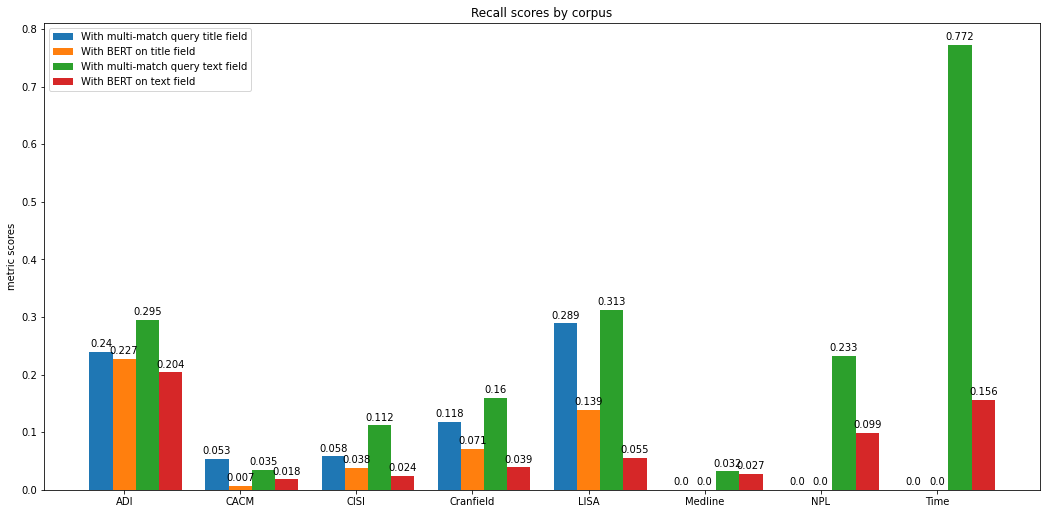

In [35]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

match_metrics_recall_title = []
match_metrics_recall_title.append(round(adi_res_match_recall_title['metric_score'], 3))
match_metrics_recall_title.append(round(cacm_res_match_recall_title['metric_score'], 3))
match_metrics_recall_title.append(round(cisi_res_match_recall_title['metric_score'], 3))
match_metrics_recall_title.append(round(cran_res_match_recall_title['metric_score'], 3))
match_metrics_recall_title.append(round(lisa_res_match_recall_title['metric_score'], 3))
match_metrics_recall_title.append(0)
match_metrics_recall_title.append(0)
match_metrics_recall_title.append(0)

bert_title_metrics_recall = []
bert_title_metrics_recall.append(round(adi_res_bert_title_recall['metric_score'], 3))
bert_title_metrics_recall.append(round(cacm_res_bert_title_recall['metric_score'], 3))
bert_title_metrics_recall.append(round(cisi_res_bert_title_recall['metric_score'], 3))
bert_title_metrics_recall.append(round(cran_res_bert_title_recall['metric_score'], 3))
bert_title_metrics_recall.append(round(lisa_res_bert_title_recall['metric_score'], 3))
bert_title_metrics_recall.append(0)
bert_title_metrics_recall.append(0)
bert_title_metrics_recall.append(0)

match_metrics_recall_text = []
match_metrics_recall_text.append(round(adi_res_match_recall_text['metric_score'], 3))
match_metrics_recall_text.append(round(cacm_res_match_recall_text['metric_score'], 3))
match_metrics_recall_text.append(round(cisi_res_match_recall_text['metric_score'], 3))
match_metrics_recall_text.append(round(cran_res_match_recall_text['metric_score'], 3))
match_metrics_recall_text.append(round(lisa_res_match_recall_text['metric_score'], 3))
match_metrics_recall_text.append(round(med_res_match_recall_text['metric_score'], 3))
match_metrics_recall_text.append(round(npl_res_match_recall_text['metric_score'], 3))
match_metrics_recall_text.append(round(time_res_match_recall_text['metric_score'], 3))

bert_text_metrics_recall = []
bert_text_metrics_recall.append(round(adi_res_bert_text_recall['metric_score'], 3))
bert_text_metrics_recall.append(round(cacm_res_bert_text_recall['metric_score'], 3))
bert_text_metrics_recall.append(round(cisi_res_bert_text_recall['metric_score'], 3))
bert_text_metrics_recall.append(round(cran_res_bert_text_recall['metric_score'], 3))
bert_text_metrics_recall.append(round(lisa_res_bert_text_recall['metric_score'], 3))
bert_text_metrics_recall.append(round(med_res_bert_text_recall['metric_score'], 3))
bert_text_metrics_recall.append(round(npl_res_bert_text_recall['metric_score'], 3))
bert_text_metrics_recall.append(round(time_res_bert_text_recall['metric_score'], 3))

labels = ['ADI','CACM', 'CISI','Cranfield', 'LISA', 'Medline', 'NPL', 'Time']

x = np.arange(len(labels))*2.5  # the label locations

width = 0.5  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width, match_metrics_recall_title , width, label='With multi-match query title field')
rects2 = ax.bar(x, bert_title_metrics_recall, width, label='With BERT on title field')
rects3 = ax.bar(x + width, match_metrics_recall_text , width, label='With multi-match query text field')
rects4 = ax.bar(x + 2*width, bert_text_metrics_recall, width, label='With BERT on text field')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('metric scores')
ax.set_title('Recall scores by corpus')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)
autolabel(rects4)

fig.tight_layout()
fig.set_figwidth(16)
fig.set_figheight(8)

plt.show()

In [36]:
from tabulate import tabulate

match_metrics_recall_title.insert(0, 'multi-match query')  
bert_title_metrics_recall.insert(0, 'BERT on title field')
match_metrics_recall_text.insert(0, 'multi-match query on text') 
bert_text_metrics_recall.insert(0, 'BERT on text field')

l = [match_metrics_recall_title, bert_title_metrics_recall, match_metrics_recall_text, bert_text_metrics_recall]
table = tabulate(l, headers=['ADI','CACM', 'CISI','Cranfield', 'LISA', 'Medline', 'NPL', 'Time'], tablefmt='orgtbl')

print(table)

|                           |   ADI |   CACM |   CISI |   Cranfield |   LISA |   Medline |   NPL |   Time |
|---------------------------+-------+--------+--------+-------------+--------+-----------+-------+--------|
| multi-match query         | 0.24  |  0.053 |  0.058 |       0.118 |  0.289 |     0     | 0     |  0     |
| BERT on title field       | 0.227 |  0.007 |  0.038 |       0.071 |  0.139 |     0     | 0     |  0     |
| multi-match query on text | 0.295 |  0.035 |  0.112 |       0.16  |  0.313 |     0.032 | 0.233 |  0.772 |
| BERT on text field        | 0.204 |  0.018 |  0.024 |       0.039 |  0.055 |     0.027 | 0.099 |  0.156 |


### Precision

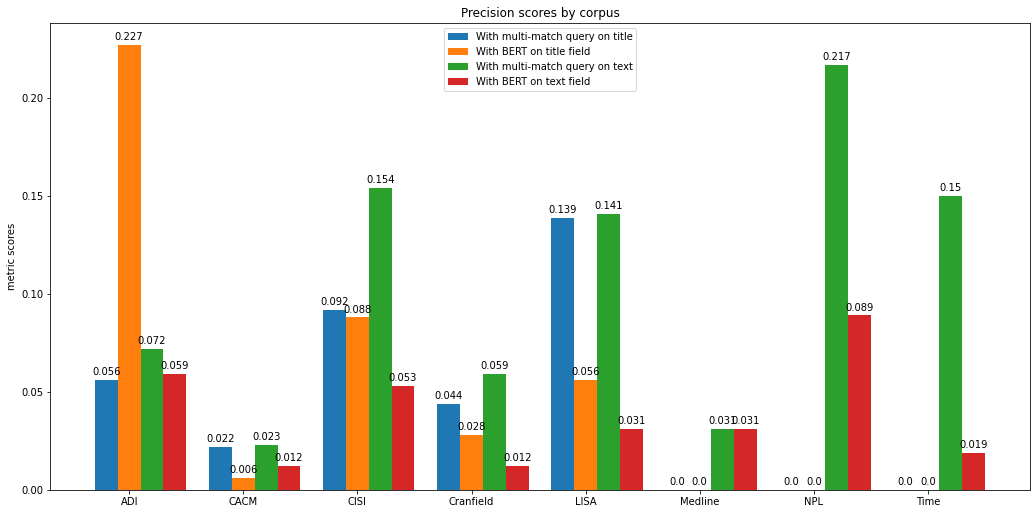

In [43]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

match_metrics_precision_title = []
match_metrics_precision_title.append(round(adi_res_match_precision_title['metric_score'], 3))
match_metrics_precision_title.append(round(cacm_res_match_precision_title['metric_score'], 3))
match_metrics_precision_title.append(round(cisi_res_match_precision_title['metric_score'], 3))
match_metrics_precision_title.append(round(cran_res_match_precision_title['metric_score'], 3))
match_metrics_precision_title.append(round(lisa_res_match_precision_title['metric_score'], 3))
match_metrics_precision_title.append(0)
match_metrics_precision_title.append(0)
match_metrics_precision_title.append(0)

bert_title_metrics_precision = []
bert_title_metrics_precision.append(round(adi_res_bert_title_precision['metric_score'], 3))
bert_title_metrics_precision.append(round(cacm_res_bert_title_precision['metric_score'], 3))
bert_title_metrics_precision.append(round(cisi_res_bert_title_precision['metric_score'], 3))
bert_title_metrics_precision.append(round(cran_res_bert_title_precision['metric_score'], 3))
bert_title_metrics_precision.append(round(lisa_res_bert_title_precision['metric_score'], 3))
bert_title_metrics_precision.append(0)
bert_title_metrics_precision.append(0)
bert_title_metrics_precision.append(0)

match_metrics_precision_text = []
match_metrics_precision_text.append(round(adi_res_match_precision_text['metric_score'], 3))
match_metrics_precision_text.append(round(cacm_res_match_precision_text['metric_score'], 3))
match_metrics_precision_text.append(round(cisi_res_match_precision_text['metric_score'], 3))
match_metrics_precision_text.append(round(cran_res_match_precision_text['metric_score'], 3))
match_metrics_precision_text.append(round(lisa_res_match_precision_text['metric_score'], 3))
match_metrics_precision_text.append(round(med_res_match_precision_text['metric_score'], 3))
match_metrics_precision_text.append(round(npl_res_match_precision_text['metric_score'], 3))
match_metrics_precision_text.append(round(time_res_match_precision_text['metric_score'], 3))

bert_text_metrics_precision = []
bert_text_metrics_precision.append(round(adi_res_bert_text_precision['metric_score'], 3))
bert_text_metrics_precision.append(round(cacm_res_bert_text_precision['metric_score'], 3))
bert_text_metrics_precision.append(round(cisi_res_bert_text_precision['metric_score'], 3))
bert_text_metrics_precision.append(round(cran_res_bert_text_precision['metric_score'], 3))
bert_text_metrics_precision.append(round(lisa_res_bert_text_precision['metric_score'], 3))
bert_text_metrics_precision.append(round(med_res_bert_text_precision['metric_score'], 3))
bert_text_metrics_precision.append(round(npl_res_bert_text_precision['metric_score'], 3))
bert_text_metrics_precision.append(round(time_res_bert_text_precision['metric_score'], 3))

labels = ['ADI','CACM', 'CISI','Cranfield', 'LISA', 'Medline', 'NPL', 'Time']

x = np.arange(len(labels))*2.5 # the label locations

width = 0.5  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width, match_metrics_precision_title , width, label='With multi-match query on title')
rects2 = ax.bar(x, bert_title_metrics_precision, width, label='With BERT on title field')
rects3 = ax.bar(x + width, match_metrics_precision_text , width, label='With multi-match query on text')
rects4 = ax.bar(x + 2*width, bert_text_metrics_precision, width, label='With BERT on text field')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('metric scores')
ax.set_title('Precision scores by corpus')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)
autolabel(rects4)

fig.tight_layout()
fig.set_figwidth(16)
fig.set_figheight(8)

plt.show()

In [44]:
from tabulate import tabulate

match_metrics_precision_title.insert(0, 'multi-match query on title') 
bert_title_metrics_precision.insert(0, 'BERT on title field')
match_metrics_precision_text.insert(0, 'multi-match query on text') 
bert_text_metrics_precision.insert(0, 'BERT on text field')

l = [match_metrics_precision_title, bert_title_metrics_precision, match_metrics_precision_text, bert_text_metrics_precision]
table = tabulate(l, headers=['ADI','CACM', 'CISI','Cranfield', 'LISA', 'Medline', 'NPL', 'Time'], tablefmt='orgtbl')

print(table)

|                            |   ADI |   CACM |   CISI |   Cranfield |   LISA |   Medline |   NPL |   Time |
|----------------------------+-------+--------+--------+-------------+--------+-----------+-------+--------|
| multi-match query on title | 0.056 |  0.022 |  0.092 |       0.044 |  0.139 |     0     | 0     |  0     |
| BERT on title field        | 0.227 |  0.006 |  0.088 |       0.028 |  0.056 |     0     | 0     |  0     |
| multi-match query on text  | 0.072 |  0.023 |  0.154 |       0.059 |  0.141 |     0.031 | 0.217 |  0.15  |
| BERT on text field         | 0.059 |  0.012 |  0.053 |       0.012 |  0.031 |     0.031 | 0.089 |  0.019 |


### F-Score

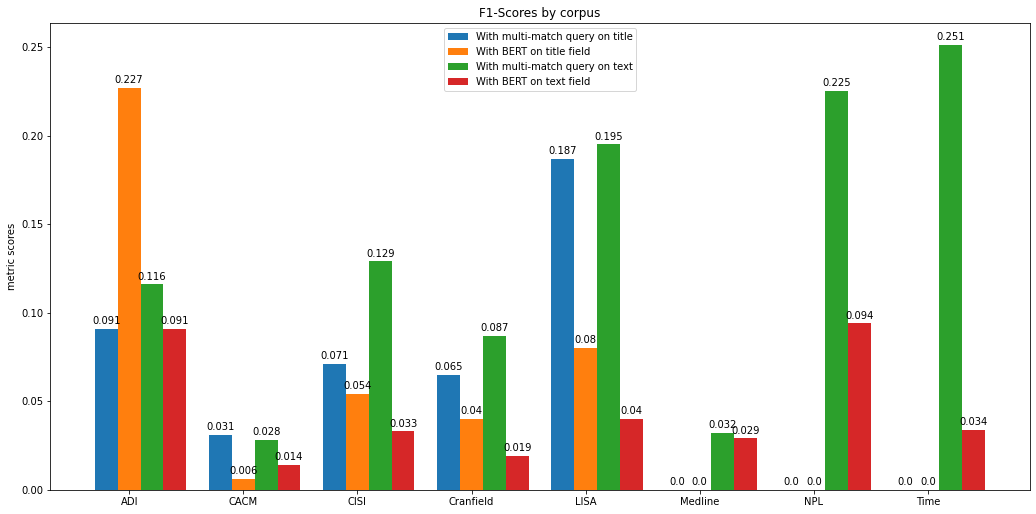

In [39]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

def f_score(recall,precision):
  if recall or precision != 0:
    fscore = (2*(recall*precision)/(recall+precision))
    return fscore

match_metrics_fscore_title = []
match_metrics_fscore_title.append(round(f_score(adi_res_match_recall_title['metric_score'], adi_res_match_precision_title['metric_score']),3))
match_metrics_fscore_title.append(round(f_score(cacm_res_match_recall_title['metric_score'], cacm_res_match_precision_title['metric_score']),3))
match_metrics_fscore_title.append(round(f_score(cisi_res_match_recall_title['metric_score'], cisi_res_match_precision_title['metric_score']),3))
match_metrics_fscore_title.append(round(f_score(cran_res_match_recall_title['metric_score'], cran_res_match_precision_title['metric_score']),3))
match_metrics_fscore_title.append(round(f_score(lisa_res_match_recall_title['metric_score'], lisa_res_match_precision_title['metric_score']),3))
match_metrics_fscore_title.append(0)
match_metrics_fscore_title.append(0)
match_metrics_fscore_title.append(0)

bert_title_metrics_fscore = []
bert_title_metrics_fscore.append(round(f_score(adi_res_bert_title_recall['metric_score'], adi_res_bert_title_precision['metric_score']),3))
bert_title_metrics_fscore.append(round(f_score(cacm_res_bert_title_recall['metric_score'], cacm_res_bert_title_precision['metric_score']),3))
bert_title_metrics_fscore.append(round(f_score(cisi_res_bert_title_recall['metric_score'], cisi_res_bert_title_precision['metric_score']),3))
bert_title_metrics_fscore.append(round(f_score(cran_res_bert_title_recall['metric_score'], cran_res_bert_title_precision['metric_score']),3))
bert_title_metrics_fscore.append(round(f_score(lisa_res_bert_title_recall['metric_score'], lisa_res_bert_title_precision['metric_score']),3))
bert_title_metrics_fscore.append(0)
bert_title_metrics_fscore.append(0)
bert_title_metrics_fscore.append(0)

match_metrics_fscore_text = []
match_metrics_fscore_text.append(round(f_score(adi_res_match_recall_text['metric_score'], adi_res_match_precision_text['metric_score']),3))
match_metrics_fscore_text.append(round(f_score(cacm_res_match_recall_text['metric_score'], cacm_res_match_precision_text['metric_score']),3))
match_metrics_fscore_text.append(round(f_score(cisi_res_match_recall_text['metric_score'], cisi_res_match_precision_text['metric_score']),3))
match_metrics_fscore_text.append(round(f_score(cran_res_match_recall_text['metric_score'], cran_res_match_precision_text['metric_score']),3))
match_metrics_fscore_text.append(round(f_score(lisa_res_match_recall_text['metric_score'], lisa_res_match_precision_text['metric_score']),3))
match_metrics_fscore_text.append(round(f_score(med_res_match_recall_text['metric_score'], med_res_match_precision_text['metric_score']),3))
match_metrics_fscore_text.append(round(f_score(npl_res_match_recall_text['metric_score'], npl_res_match_precision_text['metric_score']),3))
match_metrics_fscore_text.append(round(f_score(time_res_match_recall_text['metric_score'], time_res_match_precision_text['metric_score']),3))

bert_text_metrics_fscore = []
bert_text_metrics_fscore.append(round(f_score(adi_res_bert_text_recall['metric_score'], adi_res_bert_text_precision['metric_score']),3))
bert_text_metrics_fscore.append(round(f_score(cacm_res_bert_text_recall['metric_score'], cacm_res_bert_text_precision['metric_score']),3))
bert_text_metrics_fscore.append(round(f_score(cisi_res_bert_text_recall['metric_score'], cisi_res_bert_text_precision['metric_score']),3))
bert_text_metrics_fscore.append(round(f_score(cran_res_bert_text_recall['metric_score'], cran_res_bert_text_precision['metric_score']),3))
bert_text_metrics_fscore.append(round(f_score(lisa_res_bert_text_recall['metric_score'], lisa_res_bert_text_precision['metric_score']),3))
bert_text_metrics_fscore.append(round(f_score(med_res_bert_text_recall['metric_score'], med_res_bert_text_precision['metric_score']),3))
bert_text_metrics_fscore.append(round(f_score(npl_res_bert_text_recall['metric_score'], npl_res_bert_text_precision['metric_score']),3))
bert_text_metrics_fscore.append(round(f_score(time_res_bert_text_recall['metric_score'], time_res_bert_text_precision['metric_score']),3))

labels = ['ADI','CACM', 'CISI','Cranfield', 'LISA', 'Medline', 'NPL', 'Time']

x = np.arange(len(labels))*2.5  # the label locations

width = 0.5  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width, match_metrics_fscore_title , width, label='With multi-match query on title')
rects2 = ax.bar(x, bert_title_metrics_fscore, width, label='With BERT on title field')
rects3 = ax.bar(x + width, match_metrics_fscore_text , width, label='With multi-match query on text')
rects4 = ax.bar(x + 2*width, bert_text_metrics_fscore, width, label='With BERT on text field')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('metric scores')
ax.set_title('F1-Scores by corpus')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)
autolabel(rects3)
autolabel(rects4)

fig.tight_layout()
fig.set_figwidth(16)
fig.set_figheight(8)

plt.show()

In [40]:
from tabulate import tabulate

match_metrics_fscore_title.insert(0, 'multi-match query on title') 
bert_title_metrics_fscore.insert(0, 'BERT on title field')
match_metrics_fscore_text.insert(0, 'multi-match query on text') 
bert_text_metrics_fscore.insert(0, 'BERT on text field')

l = [match_metrics_fscore_title, bert_title_metrics_fscore,match_metrics_fscore_text,bert_text_metrics_fscore]
table = tabulate(l, headers=['ADI','CACM', 'CISI','Cranfield', 'LISA', 'Medline', 'NPL', 'Time'], tablefmt='orgtbl')

print(table)

|                            |   ADI |   CACM |   CISI |   Cranfield |   LISA |   Medline |   NPL |   Time |
|----------------------------+-------+--------+--------+-------------+--------+-----------+-------+--------|
| multi-match query on title | 0.091 |  0.031 |  0.071 |       0.065 |  0.187 |     0     | 0     |  0     |
| BERT on title field        | 0.227 |  0.006 |  0.054 |       0.04  |  0.08  |     0     | 0     |  0     |
| multi-match query on text  | 0.116 |  0.028 |  0.129 |       0.087 |  0.195 |     0.032 | 0.225 |  0.251 |
| BERT on text field         | 0.091 |  0.014 |  0.033 |       0.019 |  0.04  |     0.029 | 0.094 |  0.034 |


# Read More
Details on this experiment can be found on our [website](https://pragmalingu.de/docs/experiments/experiment2).